In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from cmath import phase
# from numpy.linalg import eig as eigenvectors
import pandas as pd
from datetime import date
import random
import matplotlib as mpl
import pickle
import scipy
import mat73
from statannotations.Annotator import Annotator
import seaborn as sns

from numpy.linalg import eigh as eigenvectors #compute real eigenvec and eigenvals (only for symmetric or Hermitian matrices)
from scipy.sparse.linalg import eigsh # BAD - but I don't know why
import networkx as nx
from sklearn import linear_model

# PCA
from sklearn.decomposition import PCA
import pandas as pd

# UMAP
import umap

# K-MEANS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn
from sklearn.preprocessing import MinMaxScaler

# Stat test
from scipy.stats import ttest_ind, ttest_1samp, pearsonr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Similaritys
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import sklearn

# Normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

2023-09-08 15:17:37.924366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 15:17:39.464488: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 15:17:40.061967: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-08 15:17:40.061982: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
intr_nodes = [0,22,180,181,203,361,362,363,364,365,374,375,387,388]
intr_nodes_labels = ['L_V1','L_MT','L_SC','R_V1',
                     'R_MT','R_SC','L_LGN','L_Pulv',
                     'R_LGN','R_Pulv','L_Amy_lat',
                     'L_Amy_med','R_Amy_lat','R_Amy_med']

random_nodes_1 = [360,27,81,247,51,297,163,391,284,250,377,393,101,24]

In [2]:
# Get data path
cwd = Path(os.getcwd())
pardir = str(cwd.parent.absolute())
projdir = os.path.dirname(pardir)
projdir = os.path.dirname(projdir)
pardir, projdir

('/home/alessio/home/projects/Blindsight_LEIDA', '/home/alessio/home')

In [5]:
# Load subjects order
mypath=projdir+'/data/Blindsight_RestingState_Data/func_STD'
patients_list = []
with open(mypath+'/list_rest.txt') as f:
    lines = f.readlines()
    patients_paths = [line[:-1] for line in lines]

# Load atlas

In [3]:
# Shafer
path = pardir+'/data/atlas/schafer/Schaefer2018_200Parcels_Kong2022_17Networks_AND_Tian_Subcortex_S2_3T_AND_SC_2.4mm.nii.gz'
path_lab = pardir+'/data/atlas/schafer/Schaefer2018_200Parcels_Kong2022_17Networks_TIAN_SC_LABELS.csv'
atlas_ = nib.load(path)
atlas = atlas_.get_fdata()
atlas_header = atlas_.header
atlas_affine = atlas_.affine
print(atlas.shape)


atlas_labels = pd.read_csv(path_lab, delimiter=';', header=None)
atlas_labels.rename(columns = {0:'from', 1:'side',2:'network',3:'area',4:'a_idx'}, inplace = True)
atlas_labels.replace('Diano', 'Tian', inplace=True)
bastardi = np.unique(atlas_labels[atlas_labels['from']=='Tian']['network'].values)
for basta in bastardi:
    atlas_labels.replace(basta, 'subcortical', inplace=True)
# nodes_labels = atlas_labels['area'].values

n_area = []
for n,a in zip(atlas_labels['network'].values, atlas_labels['area'].values):
    n_area.append(n +'-'+a)
atlas_labels['n_area'] = n_area

atlas_labels

(75, 90, 75)


from side      network      area  a_idx             n_area
0    17networks   LH     DefaultA       IPL    1.0       DefaultA-IPL
1    17networks   LH     DefaultA      PFCm    1.0      DefaultA-PFCm
2    17networks   LH     DefaultA      Temp    1.0      DefaultA-Temp
3    17networks   LH     DefaultA      Temp    2.0      DefaultA-Temp
4    17networks   LH     DefaultA  TempPole    1.0  DefaultA-TempPole
..          ...  ...          ...       ...    ...                ...
229        Tian   LH  subcortical      pPUT    NaN   subcortical-pPUT
230        Tian   LH  subcortical      aCAU    NaN   subcortical-aCAU
231        Tian   LH  subcortical      pCAU    NaN   subcortical-pCAU
232        Tian   LH  subcortical        SC    NaN     subcortical-SC
233        Tian   RH  subcortical        SC    NaN     subcortical-SC

[234 rows x 6 columns]

In [4]:
# Divides the nodes in macro areas
# Divide areas for macro areas
mas = np.unique(atlas_labels['network'].values)
mas_idx = {}
mas_dic = {} # Area index associated to each macro area (as dictionary keys)
mas_list = [] # same as mas_dic, but as a concatenation of list
for ma_idx, ma in enumerate(mas):
    mas_dic[ma_idx] = atlas_labels.index[atlas_labels['network']==ma].tolist()
    mas_list.append(atlas_labels.index[atlas_labels['network']==ma].tolist())

# Load phase locking matrix

In [5]:
# Vector indicating subject at each time points
path =pardir + '/data/Xalessio/time_all.pkl'
with open(path, 'rb') as pickle_file:
    time_all = pickle.load(pickle_file)
print(time_all.shape)


(1, 14223)


In [6]:
# Load full matrix
path =pardir + '/data/Xalessio/PL.mat'
PL = mat73.loadmat(path)

In [7]:
plm_tc = np.transpose(PL['PL_all_alessio'], (2,0,1))
plm_tc.shape

(14223, 234, 234)

# Load eigenvector decomposition

In [10]:
# Load eigenvectors
path =pardir + '/data/Xalessio/LEiDA_data.mat'
Ev_ = mat73.loadmat(path)

In [15]:
Ev = Ev_['V1_all']
print(Ev.shape)

(14223, 234)

# Subject classification

In [8]:
classif = pd.read_excel(pardir+'/data/Xalessio/davide_class_blindsight.xlsx')
# classif.drop(labels='Unnamed: 3', axis=1, inplace=True)
# new = classif['NEW ID'].values
# old = classif['OLD ID'].values
group = classif['CLASS'].values
time_points = int(time_all.shape[1]/len(group))
group_dic = {'C':0, 'B':1, 'NB':2}

groups_num = []
for idx,g in enumerate(['C', 'B', 'NB']):
    groups_num.append(np.sum(group==g))

# Group label for each time point
group_labels = np.empty((0, 1))  # [t*1]
# for c in group:
for c in group:
    cc = group_dic[c]
    sub_lab = np.full((time_points,1), cc)
    group_labels = np.concatenate((group_labels, sub_lab))
print(group_labels.shape)

# # Remove bad subjects
# new_V1 = np.empty((0, n_rois))
# for i in old:
#     m = V1[time_points*i:time_points*(i+1),:]
#     new_V1 = np.concatenate((new_V1, m))
# print(new_V1.shape)

(14223, 1)


## Metrics

In [12]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = [(1.0 / (n[i] - m)) * sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2)  for i in range(m)]

    const_term = 0.5 * m * np.log10(N)

    BIC = np.sum([n[i] * np.log10(n[i]) -
           n[i] * np.log10(N) -
         ((n[i] * d) / 2) * np.log10(2*np.pi) -
          (n[i] / 2) * np.log10(cl_var[i]) -
         ((n[i] - m) / 2) for i in range(m)]) - const_term

    return(BIC)

# METHOD FOR K-MEANS COMPUTING AND SCORING

def get_km_score(k, X):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    labels = km.predict(X)
    inertia = km.inertia_
    silhouette = silhouette_score(X, labels)
    calinksi = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    bic = compute_bic(km, X)
    return km, inertia, silhouette, calinksi, davies, bic

def get_km_centr_label(k, X):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    centr = km.cluster_centers_
    labels = km.predict(X)
    return km, centr, labels

In [13]:
# Some metrics
def graph_metrics(METRIC, graph):
    edges_full = 345*345
    if METRIC=='number_connected_components':
        metric = nx.number_connected_components(graph) # number of connected components
    elif METRIC=='size_giant_component':
        metric = len(sorted(nx.connected_components(graph), key=len, reverse=True)[0]) # size giant component
    elif METRIC=='average_shortest_path':
        GiantComponent = graph.subgraph(max(nx.connected_components(graph), key=len)).copy()                    
        metric = nx.average_shortest_path_length(GiantComponent) # Average shortest path inside the giant component
    elif METRIC=='global_average_shortest_path':
        sps = [list(nx.shortest_path_length(graph.subgraph(cc).copy())) for cc in nx.connected_components(graph)]
        global_sps = []
        for sp in sps:
            for l in sp:
                global_sps += list(l[1].values())
        metric = np.mean(global_sps) # Average shortest path (global)
    elif METRIC=='fraction_of_edges':
        edges = graph.number_of_edges()
        metric = edges/edges_full # fraction of remaining edges inside the graph
    elif METRIC=='node_wih_link':
        nodes = len([n for n in graph.nodes if len(list(graph.neighbors(n))) > 0])
        metric = nodes/nodes_full # node with at least a link
    #                 centr = nx.betweenness_centrality(GiantComponent)
    #                 max_centr_key = max(centr, key=centr.get)
    #                 max_centr = centr[max_centr_key]
    #                 metric = max_centr
    #                 metric = nx.betweenness_centrality(graph)[node] # centrality of a selected node
    #             print(metric)
    elif METRIC=='degree_distribution':
        d = sorted((d for n, d in graph.degree() if d!=0), reverse=True) # degree distribution
    elif METRIC=='average_degree':
        metric = np.mean([d for n, d in graph.degree() if d!=0])
    elif METRIC=='local_efficiency':
        metric = nx.local_efficiency(graph)
    elif METRIC=='global_efficiency':
        metric = nx.global_efficiency(graph)
    return metric

# LEADING EIGENVECTOR DYNAMICS ANALYSIS (LEiDA)

This function clusters and analyses BOLD data using LEiDA

- 1. Compute the leading eigenvector V1
- 2. Clusters the Leading Eigenvectors into recurrent PL states
- 3. Analyzes the percentage of occupancy and lifetime of each PL state
- 4. Calculates statistical signigifance between groups
- 5. Plots PL states and group differences for a given clustering solution
- 6. Evaluate transition probability between states

## 1 - Compute the Leading Eigenvectors from the BOLD datasets

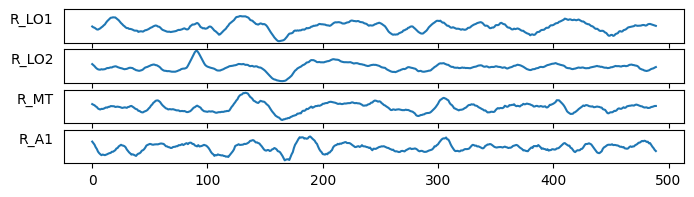

In [31]:
n = 4
lab = atlas_labels['area'].values[no_les_idx]
fig,axs = plt.subplots(n,1, sharey=True, sharex=True, figsize=(8,2)) 
for i in range(n):
    idx = i+180
    axs[i].plot(ts[no_les_idx][idx][:490]);
    axs[i].set_ylabel(lab[idx], rotation='horizontal', ha='right')
    axs[i].set_yticks([])

In [32]:
# Data normalization
for i in range(subjects):
    for j,ts_r in enumerate(ts):
        tc = ts_r[i*490:(i+1)*490]
        tc = (tc - tc.mean())/tc.std()
        if j==0:
            tc = np.expand_dims(tc,axis=0)
            prev = tc
        else:
            tc = np.expand_dims(tc,axis=0)
            prev = np.concatenate((prev,tc), axis=0) 
#         print(prev.shape)
    if i==0:
        ts_norm = prev
    else:
        ts_norm = np.concatenate((ts_norm, prev), axis=1) 
    print(ts_norm.shape)

(394, 490)
(394, 980)
(394, 1470)
(394, 1960)
(394, 2450)
(394, 2940)
(394, 3430)
(394, 3920)
(394, 4410)
(394, 4900)
(394, 5390)
(394, 5880)
(394, 6370)
(394, 6860)
(394, 7350)
(394, 7840)
(394, 8330)
(394, 8820)
(394, 9310)
(394, 9800)
(394, 10290)
(394, 10780)
(394, 11270)
(394, 11760)
(394, 12250)
(394, 12740)
(394, 13230)
(394, 13720)
(394, 14210)
(394, 14700)
(394, 15190)
(394, 15680)
(394, 16170)
(394, 16660)
(394, 17150)
(394, 17640)


In [33]:
vec_phase = np.vectorize(phase) # to apply phase extraction to a numpy matrix

In [34]:
Phase_BOLD = vec_phase(hilbert(ts)) # phase of each time points of each subject (concatenate) of each roi

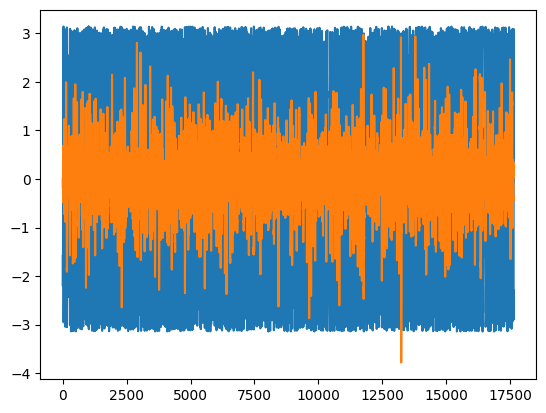

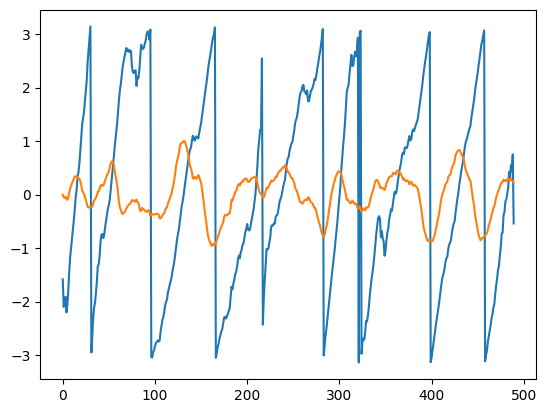

In [35]:
plt.figure()
plt.plot(Phase_BOLD[2])

plt.plot(ts[2])

for i in range(33):
    plt.figure()
    plt.plot(Phase_BOLD[2][i*490:(i+1)*490])
    plt.plot((ts[2][i*490:(i+1)*490]-ts[2][i*490:(i+1)*490].mean())/ts[2][i*490:(i+1)*490].max())
    break

In [ ]:
# ### COMPUTE PHASE LOC ###

# # Initialize phase loc tensor (roi*roi*time)
# iFC = np.empty((n_rois,n_rois,time_points*subjects))
# # Loop over time
# for t in range(time_points*subjects):
#     if t%500==0:
#         print(round(100*t/(time_points*subjects), 2), ' %')
#     # Loop over areas
#     for i in range(n_rois):
#         for j in range(n_rois):
#             iFC[i,j,t] = np.cos(Phase_BOLD[i,t] - Phase_BOLD[j,t])
            
# iFC.shape

In [52]:
t_iFC = np.transpose(iFC) # t_IFC = [t*rois*rois]

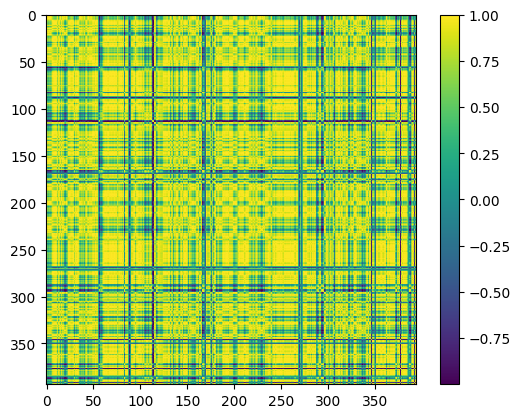

In [53]:
plt.imshow(t_iFC[1000])
plt.colorbar()

In [ ]:
# plt.imshow(t_iFC_noles[1000])
# plt.colorbar()

In [ ]:
# # CHECK MATRIX SIMMETRY

# # creating a function that returns true if the matrix is symmetric
# # else false by accepting the input matrix, no of rows as arguments
# def checkingSymmetric(inputMatrix, rows):
#    # traversing through the rows of a matrix
#       for p in range(rows):
#          # traversing the columns of a current row
#             for q in range(rows):
#                # checking whether the current element is not equal to its transpose
#                   if (inputMatrix[p][q] != inputMatrix[q][p]):
#                      # returning False if the condition is true
#                      return False
#    # else returning True
#       return True
# # input matrix
# inputMatrix = [[6, 3, 5], [3, 2, 4], [5, 4, 6]]
# if (checkingSymmetric(ex, 394)):
#    print("Input matrix is a Symmetric matrix")
# else:
#    print("Input matrix is NOT a Symmetric matrix")



In [ ]:
# # EXAMPLE

# # plt.imshow(t_iFC[1000])
# # plt.colorbar()
# ex = t_iFC[607]
# w, v = eigenvectors(ex)
# am = np.argmax(w) # Take the greatest eigenvalue
# print(w.shape, v.shape)
# fig = plt.figure()
# plt.barh(range(w.shape[0]), w)
# fig = plt.figure()
# plt.barh(range(v[am].shape[0]), v[am])

In [ ]:
# # BAD EXAMPLE - i don't know why
# t_iFC = np.transpose(iFC) # t_IFC = [t*rois*rois]

# # plt.imshow(t_iFC[1000])
# # plt.colorbar()
# ex = t_iFC[0]

# eigenval, eigenvec = eigsh(ex, k=1)  # k=1 to get the largest eigenvalue/eigenvector
# print(eigenval.shape, eigenvec.shape)
# # V1 = eigenvectors[:, 0]


# # w, v = eigenvectors(ex)
# print(eigenval)
# fig = plt.figure()
# plt.barh(range(eigenvec[:,0].shape[0]), eigenvec[:,0])
# # print(eigenvec)

In [56]:
### COMPUTE EIGENVECTORS FOR EACH iFC ###

t_iFC = np.transpose(iFC) # t_iFC = [t*rois*rois]

# Remove lesioned rois
t_iFC_noles = t_iFC[:][:,no_les_idx][:,:,no_les_idx]
print(t_iFC_noles.shape)

V1 = np.empty((0, len(no_les_idx)))
for t,m in enumerate(t_iFC_noles):
    if t%500==0:
        print(round(100*t/(time_points*subjects), 2), ' %')
#     w, v = eigenvectors(m) # w: eigenvalues, v: eigenvectors
#     am = np.argmax(w) # Take the greatest eigenvalueù
#     v1 = v[am]
    w, v = eigsh(m, k=1)  # k=1 to get the largest eigenvalue/eigenvector
#     # PLOT each eigenvector
#     fig = plt.figure()
#     plt.barh(range(v[am].shape[0]), v[am])
#     plt.show()
    v1 = v[:,0]
    if np.sum(v1)>0:
        v1 = -v1 # I want the greatest communities on the left side
    v1 = np.expand_dims(v1,axis=0)
    # I take only the leading eigenvector
    V1 = np.concatenate((V1, v1), axis=0) # V1 = [t*n_rois]

(17640, 352, 352)
0.0  %
2.83  %
5.67  %
8.5  %
11.34  %
14.17  %
17.01  %
19.84  %
22.68  %
25.51  %
28.34  %
31.18  %
34.01  %
36.85  %
39.68  %
42.52  %
45.35  %
48.19  %
51.02  %
53.85  %
56.69  %
59.52  %
62.36  %
65.19  %
68.03  %
70.86  %
73.7  %
76.53  %
79.37  %
82.2  %
85.03  %
87.87  %
90.7  %
93.54  %
96.37  %
99.21  %


In [57]:
V1.shape

(17640, 352)

In [ ]:
# # # Plot all the overlapped leading eigenvectors (of each time points)

# V1 = new_V1
# fig = plt.figure()
# for j in range(V1.shape[0]):
#     plt.barh(range(V1[j+1000].shape[0]),V1[j+1000],color='red', alpha=0.02)
#     if j==10:
#         break

#### START FROM HERE

In [14]:
# DEFINE SUBJECTS GROUP AND REMOVE BAD SUBJECTS
##### LOOK AT NEW CLASSIFICATION MATTEO SENT ME #####


classif = pd.read_csv(projdir+'/data/Blindsight_RestingState_Data/classification/davide_class_blindsight_28062023.csv',
                      delimiter=';')
# classif.drop(labels='Unnamed: 3', axis=1, inplace=True)
# new = classif['NEW ID'].values
# old = classif['OLD ID'].values
group = classif['CLASS'].values
group_dic = {'C':0, 'B':1, 'NB':2}

groups_num = []
for idx,g in enumerate(['C', 'B', 'NB']):
    groups_num.append(np.sum(group==g))

# Group label for each time point
group_labels = np.empty((0, 1))  # [t*1]
# for c in group:
for c in group:
    cc = group_dic[c]
    sub_lab = np.full((time_points,1), cc)
    group_labels = np.concatenate((group_labels, sub_lab))
print(group_labels.shape)

# # Remove bad subjects
# new_V1 = np.empty((0, n_rois))
# for i in old:
#     m = V1[time_points*i:time_points*(i+1),:]
#     new_V1 = np.concatenate((new_V1, m))
# print(new_V1.shape)

(17640, 1)


In [15]:
group

array(['B', 'NB', 'NB', 'NB', 'B', 'NB', 'NB', 'NB', 'B', 'B', 'NB', 'NB',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'],
      dtype=object)

In [16]:
# # ########## SALVA TUTTO ##########
today = date.today()
DATE = today.strftime("%d%m%Y")
print(DATE)

# # # Phase BOLD
# np.save('output/PhaseBOLD_'+DATE+'_allsubplus_newfilt.npy', Phase_BOLD)

# # # iFC
# np.save('output/iFC_'+DATE+'_allsubplus_newfilt.npy', iFC)

# # no lesion transpose iFC
# np.save('output/t_iFC_noles_'+DATE+'_allsubplus_newfilt.npy', t_iFC_noles)

# # leading eigenvector for each time point
# np.save('output/V1_eigsh_'+DATE+'_allsubplus_newfilt.npy', V1)

# leading eigenvector for each time point
# np.save('output/V1_eigsh_'+DATE+'_allsubplus_newfilt_NOLES.npy', V1)

04082023


In [17]:
# W1 = np.load('output/W1_eigsh_30062023_allsubplus_newfilt_NOLES.npy')
V1 = np.load('output/V1_eigsh_31072023_allsubplus_newfilt_NOLES.npy')
# # V1 = np.load('output/V1_eigsh_28062023_allsubplus_newfilt.npy')
# Phase_Bold = np.load('output/PhaseBOLD_28062023_allsubplus_newfilt.npy')
# iFC = np.load('output/iFC_28062023_allsubplus_newfilt.npy')
# t_iFC_noles = np.load('output/t_iFC_noles_11072023_allsubplus_newfilt.npy')

In [17]:
# V1 = np.load('output/V1_eigsh_31052023_newfilt.npy')
# Phase_Bold = np.load('output/PhaseBOLD_31052023_newfilt.npy')
# iFC = np.load('output/iFC_31052023_newfilt.npy')

In [18]:
# # NORMALIZATION
# scaler = StandardScaler()
# # scaler = MinMaxScaler()

# # Fit the scaler to the data and transform the data
# V1 = scaler.fit_transform(V1)

# std = V1.std(axis=0)
# mean = V1.mean(axis=0)
# maxx = np.abs(V1).max(axis=0)
# V1_new = np.empty((0,394))
# for x in V1:
#     V1_new = np.concatenate((V1_new, np.expand_dims(np.divide(x,maxx), axis=0)), axis=0)
# V1_norm = V1_new
# # X_norm = (X - mean)/std
# plt.barh(range(V1_norm.shape[1]), V1_norm[0])

In [19]:
# V1_old = np.copy(V1)
# V1 = np.copy(V1_norm)

# 1.1 UMAP representation of leading eigenvectors

In [18]:
V1.shape, group_labels.shape

((17640, 352), (17640, 1))

In [19]:
# n_class = 3
# reducer = umap.UMAP(n_neighbors=15)
# # reducer = umap.UMAP()
# reducer.fit(V1)
# embedding = reducer.transform(V1)
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     c=group_labels, alpha=0.8, s=0.1)
# plt.colorbar(boundaries=np.arange(n_class+1)-0.5).set_ticks(np.arange(n_class))
# plt.gca().set_aspect('equal', 'datalim')

## 2 - Clusters the Leading Eigenvectors into recurrent PL states

In [20]:
# LOAD LEADING EIGENVECTORS FOR EACH TIME POINTS

### 2.1 - K-MEANS CLUSTERING

In [21]:
V1[0].shape

(352,)

In [22]:
# METHOD FOR K-MEANS COMPUTING AND SCORING

def get_km_score(k, X, pca=False, pca_X=None):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    labels = km.predict(X)
    inertia = km.inertia_
    if not pca:
        silhouette = silhouette_score(X, labels)
        calinksi = calinski_harabasz_score(X, labels)
        davies = davies_bouldin_score(X, labels)
        bic = compute_bic(km, X)
    else:
        silhouette = silhouette_score(pca_X, labels)
        calinksi = calinski_harabasz_score(pca_X, labels)
        davies = davies_bouldin_score(pca_X, labels)
        bic = None
    return km, inertia, silhouette, calinksi, davies, bic

def get_km_centr_label(k, X):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    centr = km.cluster_centers_
    labels = km.predict(X)
    return km, centr, labels


In [ ]:
inertia = []
silhouette = []
calinksi = []
davies = []
bics = []
ks = []
gs_counts = []
k_max = 15
eps=0.00001
for k in range(2, k_max):
    print(k,' /',str(k_max))
    km, i, s, c, d, b = get_km_score(k, V1)
    inertia.append(i)
    silhouette.append(s)
    calinksi.append(c)
    davies.append(d)
    bics.append(b)
    ks.append(k)
    clust = km.cluster_centers_
    gs_count = 0
    for s in clust:
        if np.sum(s<0+eps)==s.shape[-1]:
            gs_count += 1
    gs_counts.append(gs_count)    
    
fig = plt.figure(figsize=(5,2))
plt.title('Silhouette')
plt.plot(ks, silhouette)
plt.xlabel('K')

fig = plt.figure(figsize=(5,3))
plt.title('Calinksi')
plt.plot(ks, calinksi)

fig = plt.figure(figsize=(5,3))
plt.title('Davies')
plt.plot(ks, davies)

fig = plt.figure(figsize=(5,3))
plt.title('Inertia')
plt.plot(ks, inertia)

fig = plt.figure(figsize=(5,3))
plt.title('BIC')
plt.plot(ks, bics)

fig = plt.figure(figsize=(5,3))
plt.title('# of Global States')
plt.plot(ks, gs_counts)

In [24]:
# GET STATE OF BELONGING FOR EACH EIGENVECTOR
num_states = 3
# num_states = 5 # For whole brain
# num_states = 8 # For interesting nodes
_, states, state_labels = get_km_centr_label(num_states, V1)
print(state_labels.shape)

(17640,)


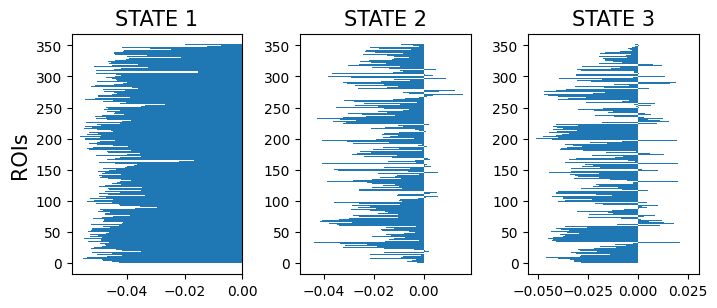

In [25]:
# PLot CENTROIDS
fig, axs = plt.subplots(1,num_states,figsize=(7,3))
fig.tight_layout()
for i in range(num_states):
    axs[i].set_title('STATE {}' .format(i+1), fontsize=15)
    axs[i].barh(range(states[i].shape[0]), states[i], height=1);
#              tick_label=nodes_labels)
    axs[0].set_ylabel('ROIs', fontsize=15)

In [26]:
# Divide areas for macro areas
mas = np.unique(atlas_labels['macro_area'].values)
mas_idx = {}
mas_dic = {}
new_mas = ['subcortical'] # put inside a unique macro area all the subcortical regions
subcort = ['Superior Colliculus','Thalamus', 'Tian_Accumbens',
           'Tian_Amygdala', 'Tian_Caudate', 'Tian_Pallidus', 'Tian_Putamen',
           'Tian_Thalamus', 'Substantia_Nigra']
mas_dic[0] = []
i = 1
for ma in mas:
    # put inside a unique macro area all the subcortical regions
    if ma not in subcort:
        mas_idx[ma] = i
        mas_dic[i] = []
        i += 1
        new_mas.append(ma)
    else:
        mas_idx[ma] = 0
        
for ii,i in enumerate(no_les_idx):
    mas_dic[mas_idx[atlas_labels.iloc[i]['macro_area']]].append(ii)

In [27]:
# reorder areas according to macroareas in the state vectors
states_reord = np.zeros((3,len(no_les_idx)))
c = 0
for i in mas_dic.keys():
    for a in mas_dic[i]:
        states_reord[0,c] = states[0,a]
        states_reord[1,c] = states[1,a]
        states_reord[2,c] = states[2,a]
        c += 1
#     print(states_reord[:,new_idx])

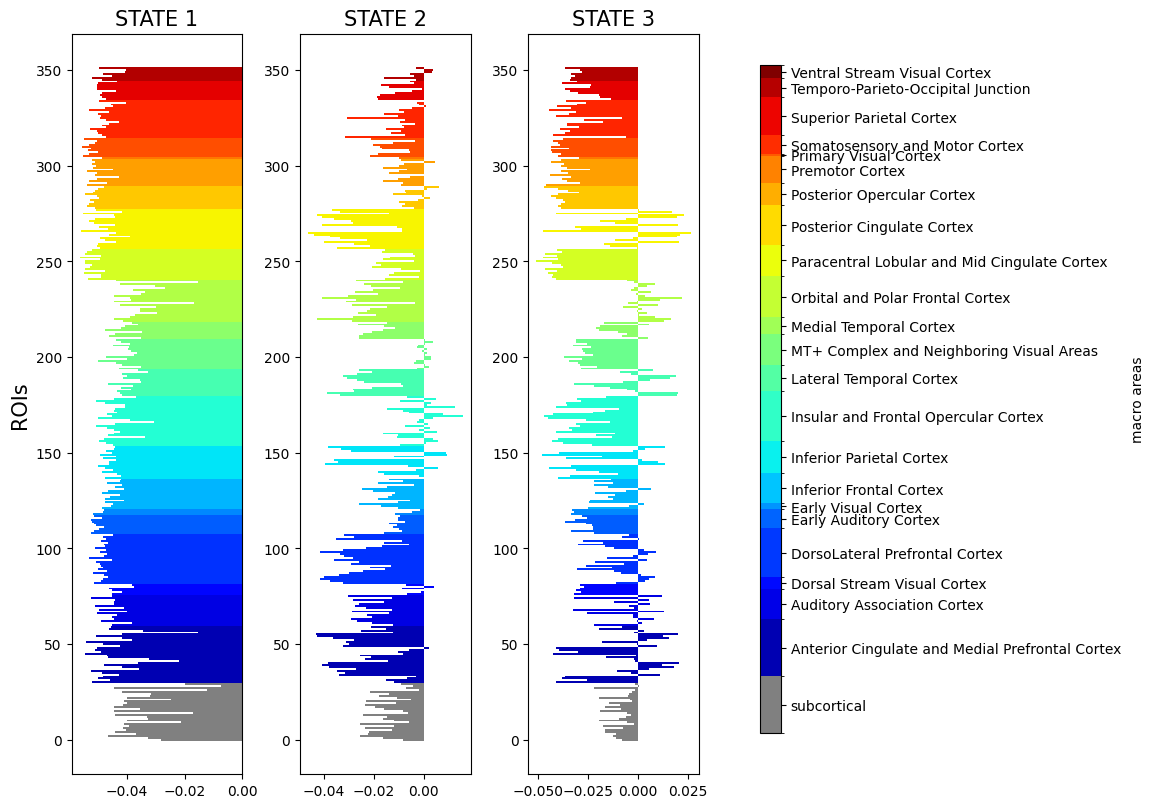

In [28]:
# Colormap definition
import matplotlib as mpl

new_mas_l = [m for m in new_mas]

mas_dic_count = [len(mas_dic[k]) for k in mas_dic.keys()]
mas_dic_count_new = [0]
prev = 0
for c in mas_dic_count:
    prev += c/np.sum(mas_dic_count)
    mas_dic_count_new.append(prev)
mas_dic_count = mas_dic_count_new

cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
       'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(0, len(new_mas_l)-1, len(new_mas_l))
norm = mpl.colors.BoundaryNorm(mas_dic_count, cmap.N)

states_mas_color = []
mas_color = []
for k in mas_dic.keys():
    i = 0
    mas_color.append(cmap(k/len(new_mas_l)))
    for _ in mas_dic[k]:
        states_mas_color.append(cmap(k/len(new_mas_l)))
        i += 1
        
# PLot reordered CENTROIDS (with colors)

fig, axs = plt.subplots(1,num_states,figsize=(7,8))
fig.tight_layout()
for i in range(num_states):
    axs[i].set_title('STATE {}' .format(i+1), fontsize=15)
    axs[i].barh(range(states_reord[i].shape[0]), states_reord[i], height=1, color=states_mas_color);
#              tick_label=nodes_labels)
    axs[0].set_ylabel('ROIs', fontsize=15)
    
# create a second axes for the colorbar
ax2 = fig.add_axes([1.05, 0.1, 0.03, 0.835])
# cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
#      spacing='proportional', boundaries=mas_dic_count)
# cb.set_ticklabels(np.concatenate((new_mas,np.asarray(['_'])), axis=0))
cb = fig.colorbar(
     mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
     cax=ax2,
     boundaries=mas_dic_count,
     spacing='proportional'
)
cb.set_ticklabels(np.concatenate((new_mas,np.asarray(['_'])), axis=0))
cb.ax.locator_params(axis='y', nbins=len(new_mas_l)+1)

ax2.set_ylabel('macro areas', size=10);
loc = []
for i in range(len(mas_dic_count)-1):
    loc.append(mas_dic_count[i] + (mas_dic_count[i+1]-mas_dic_count[i])/2)
cb.set_ticks(loc)
cb.set_ticklabels(new_mas_l)
# cb.set_ticklabels(np.concatenate((new_mas,np.asarray(['_'])), axis=0))


In [ ]:
# sizes = [len(mas_dic[k]) for k in range(len(new_mas_l))]

# fig, ax = plt.subplots()
# ax.pie(sizes, labels=new_mas, colors=mas_color, rotatelabels=True);

In [29]:
# List for each state the macro areas involved in in the positive cluster
intr_mareas = []
for c,state in enumerate(states):
    intr_mareas.append([])
    for i,a in enumerate(state):
        if a>0:
            ma = atlas_labels[atlas_labels['area']==no_les_labels[i]]['macro_area'].values[0]
            if ma not in intr_mareas[c]:
                intr_mareas[c].append(ma)

In [30]:
intr_mareas

[[],
 ['Dorsal Stream Visual Cortex',
  'MT+ Complex and Neighboring Visual Areas',
  'Premotor Cortex',
  'Insular and Frontal Opercular Cortex',
  'Posterior Opercular Cortex ',
  'Inferior Parietal Cortex ',
  'Ventral Stream Visual Cortex',
  'Superior Parietal Cortex',
  'Anterior Cingulate and Medial Prefrontal Cortex '],
 ['Posterior Cingulate Cortex',
  'Anterior Cingulate and Medial Prefrontal Cortex ',
  'Orbital and Polar Frontal Cortex',
  'DorsoLateral Prefrontal Cortex ',
  'Inferior Frontal Cortex',
  'Medial Temporal Cortex ',
  'Auditory Association Cortex ',
  'Lateral Temporal Cortex',
  'Inferior Parietal Cortex ',
  'Substantia_Nigra']]

In [41]:
# Save centroids as brain maps
# today's date
today = date.today()
DATE = today.strftime("%d%m%Y") # Date for name savings


c = 0
# Loop over states
for state in states[1:]:
    bmap = np.zeros(atlas.shape)
    # Loop over rois
    for i,r in enumerate(no_les_idx):
#         print(state[i])
        if state[i]>0:
            cord = np.where(atlas==r+1)
            bmap[cord] = state[i]
    print(bmap.max())
    print(np.sum(bmap!=0))
    nii_img=nib.Nifti1Image(bmap, atlas_affine)
    nib.save(nii_img, 'output/centroids/kmeans/kmeans_centroid_'+str(c+1)+'_'+DATE+'.nii.gz')
    c += 1

0.015709895332198263
3895
0.026741408895310223
12357


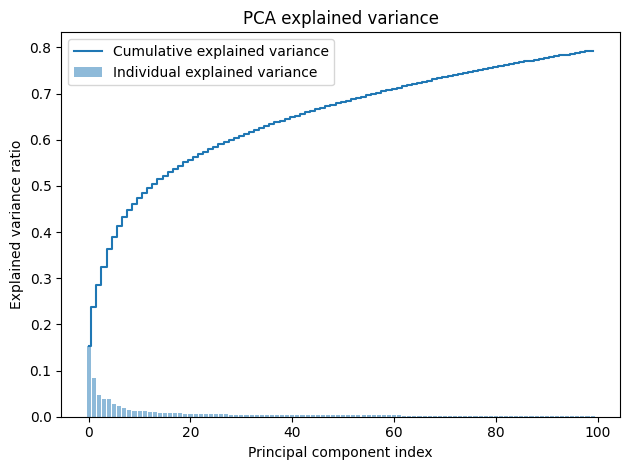

In [70]:
# Cluster visualzation through PCA
# PCA
pca = sklearn.decomposition.PCA(n_components=100)
pca.fit(V1)
V1_pca = pca.transform(V1)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.title('PCA explained variance')
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

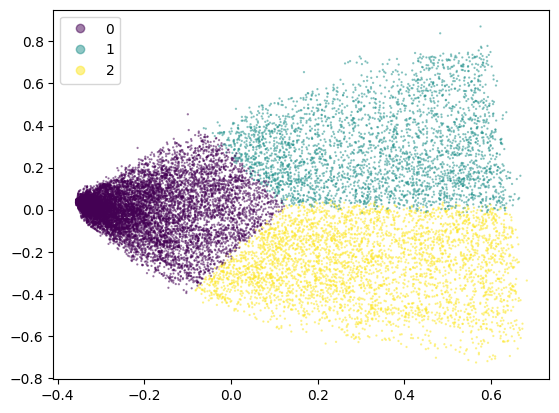

In [71]:
fig, ax = plt.subplots()
scat = ax.scatter(V1_pca[:,0], V1_pca[:,1], c = state_labels, s=0.4, alpha=0.5)
# scat = ax.scatter(V1_pca[:,0], V1_pca[:,1], c = group_labels, s=0.4, alpha=0.5)


plt.legend(*scat.legend_elements())

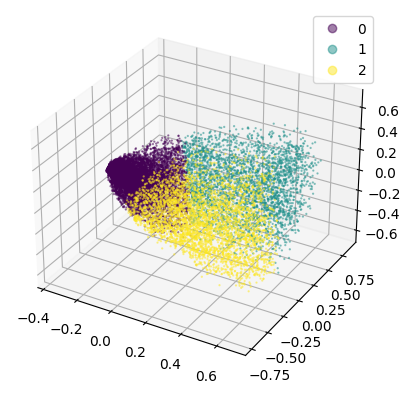

In [72]:
ax = plt.axes(projection='3d')
scat = ax.scatter3D(V1_pca[:,0], V1_pca[:,1], V1_pca[:,2], c = state_labels, s=0.4, alpha=0.5)
# scat = ax.scatter3D(V1_pca[:,0], V1_pca[:,1], V1_pca[:,2], c = group_labels, s=0.4, alpha=0.5)
plt.legend(*scat.legend_elements())


In [235]:
silly = []
dave = []
cally = []
for i in range(2, 30):
    s = silhouette_score(V1_pca[:,:i], state_labels)
    d = davies_bouldin_score(V1_pca[:,:i], state_labels)
    c = calinski_harabasz_score(V1_pca[:,:i], state_labels)
    print(str(i)+' components ', 'sil ', s, 'dav', d, 'cal', c)
    silly.append(s)
    dave.append(d)
    cally.append(c)
    

2 components  sil  0.539218014605599 dav 0.7812905103655688 cal 21373.1692750987
3 components  sil  0.4686850001380255 dav 1.0542340539462471 cal 12756.942346626949
4 components  sil  0.4345657684970939 dav 1.2478567497393702 cal 9507.311206682047
5 components  sil  0.40843044214677654 dav 1.4181960425246531 cal 7652.623549180141
6 components  sil  0.390541041672809 dav 1.5251283235872697 cal 6721.158466927494
7 components  sil  0.3766270601481763 dav 1.6090487031667464 cal 6079.013296289486
8 components  sil  0.36140791658748633 dav 1.6692449767163449 cal 5617.658485707073
9 components  sil  0.3534840097950102 dav 1.7195269851554915 cal 5306.805133949435
10 components  sil  0.34780140104914054 dav 1.7610708738565168 cal 5078.198885819235
11 components  sil  0.341999738256847 dav 1.79865904191218 cal 4875.158517612256
12 components  sil  0.33757060929383365 dav 1.836511157804831 cal 4690.1136409910405
13 components  sil  0.33288212821852375 dav 1.8666916287306377 cal 4541.5262357632055

Text(0.5, 0, 'PCA components')

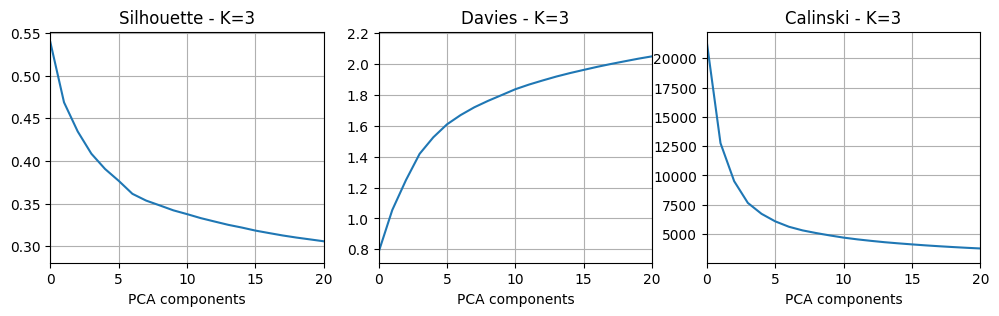

In [237]:
fig,axs = plt.subplots(1,3, figsize=(12,3))
axs[0].plot(silly)
axs[0].set_xlim(0,20)
axs[0].set_title('Silhouette - K=3')
axs[0].grid()
axs[0].set_xlabel('PCA components')
axs[1].plot(dave)
axs[1].set_title('Davies - K=3')
axs[1].set_xlim(0,20)
axs[1].grid()
axs[1].set_xlabel('PCA components')
axs[2].plot(cally)
axs[2].set_title('Calinski - K=3')
axs[2].set_xlim(0,20)
axs[2].grid()
axs[2].set_xlabel('PCA components')


 # comp= 2 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 3 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 4 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 5 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 6 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 7 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15


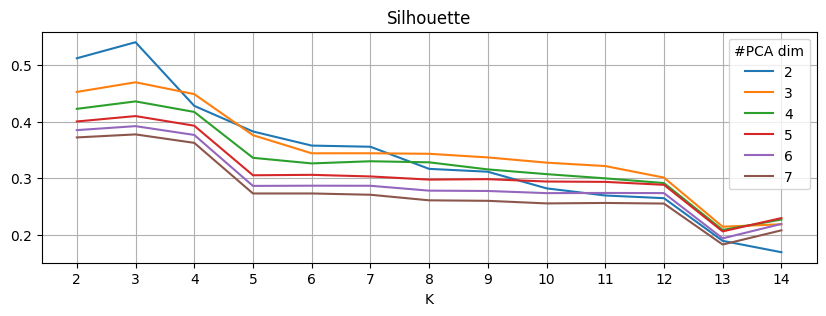

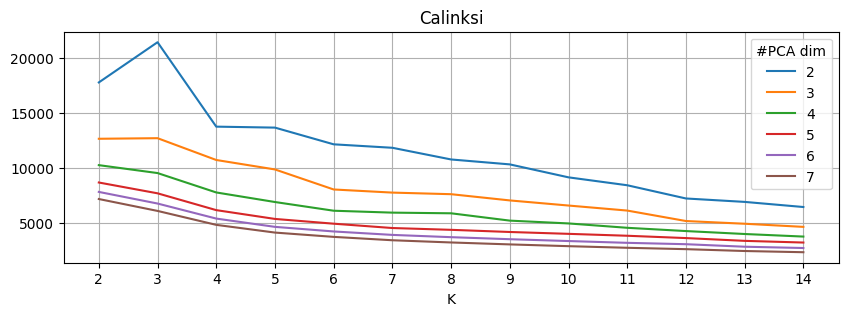

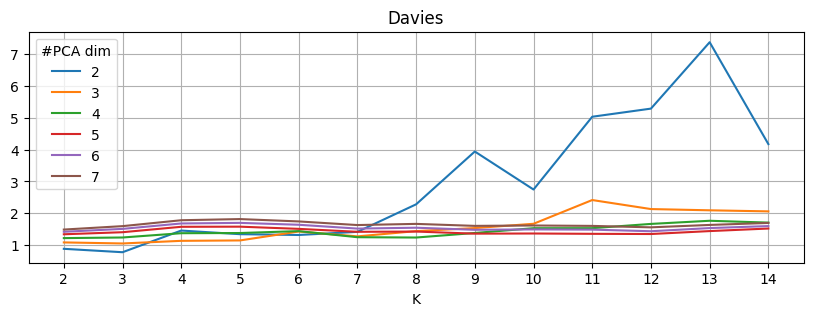

In [73]:
# K eval in PCA space

silhouettes = []
calinksis = []
daviess = []
kss = []
for comp in range(2,8):
    print('\n # comp=', comp, '\n')
    inertia = []
    silhouette = []
    calinksi = []
    davies = []
    bics = []
    ks = []
    gs_counts = []
    k_max = 15
    eps=0.00001
    for k in range(2, k_max):
        print(k,' /',str(k_max))
        km, i, s, c, d, b = get_km_score(k, V1, pca=True, pca_X=V1_pca[:,:comp])
        inertia.append(i)
        silhouette.append(s)
        calinksi.append(c)
        davies.append(d)
        bics.append(b)
        ks.append(k)
        clust = km.cluster_centers_
        gs_count = 0
        for s in clust:
            if np.sum(s<0+eps)==s.shape[-1]:
                gs_count += 1
        gs_counts.append(gs_count)    

    silhouettes.append(silhouette)
    calinksis.append(calinksi)
    daviess.append(davies)
    kss.append(ks)
    
fig = plt.figure(figsize=(10,3))
plt.title('Silhouette')
plt.xlabel('K')
for c,silhouette in enumerate(silhouettes):
    plt.plot(ks, silhouette, label=str(c+2))
plt.xticks([t for t in range(2,15)])
plt.grid()
plt.legend(title='#PCA dim')

fig = plt.figure(figsize=(10,3))
plt.title('Calinksi')
plt.xlabel('K')
for c,calinksi in enumerate(calinksis):
    plt.plot(ks, calinksi, label=str(c+2))
plt.xticks([t for t in range(2,15)])
plt.grid()
plt.legend(title='#PCA dim')
    
fig = plt.figure(figsize=(10,3))
plt.title('Davies')
plt.xlabel('K')
for c,davies in enumerate(daviess):
    plt.plot(ks, davies, label=str(c+2))
plt.xticks([t for t in range(2,15)])
plt.grid()
plt.legend(title='#PCA dim')

# fig = plt.figure(figsize=(5,3))
# plt.title('Inertia')
# plt.plot(ks, inertia)

# fig = plt.figure(figsize=(5,3))
# plt.title('BIC')
# plt.plot(ks, bics)

# fig = plt.figure(figsize=(5,3))
# plt.title('# of Global States')
# plt.plot(ks, gs_counts)

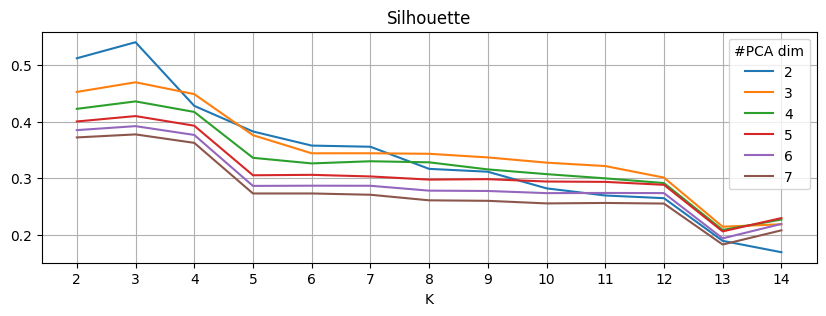

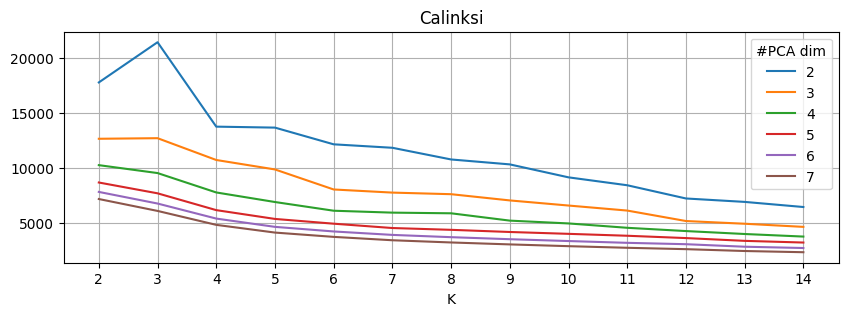

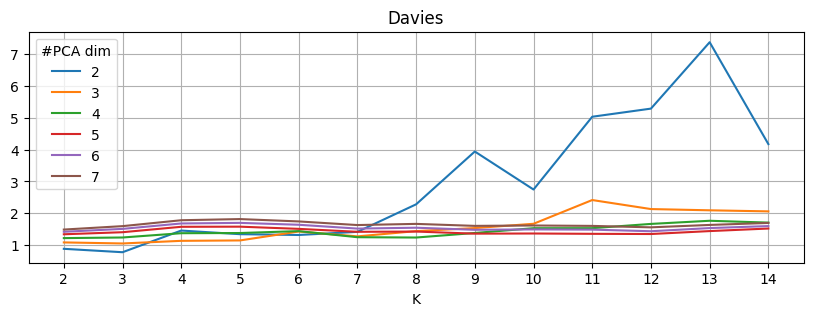

In [75]:
fig = plt.figure(figsize=(10,3))
plt.title('Silhouette')
plt.xlabel('K')
for c,silhouette in enumerate(silhouettes):
    plt.plot(ks, silhouette, label=str(c+2))
plt.xticks([t for t in range(2,15)])
plt.grid()
plt.legend(title='#PCA dim')

fig = plt.figure(figsize=(10,3))
plt.title('Calinksi')
plt.xlabel('K')
for c,calinksi in enumerate(calinksis):
    plt.plot(ks, calinksi, label=str(c+2))
plt.xticks([t for t in range(2,15)])
plt.grid()
plt.legend(title='#PCA dim')
    
fig = plt.figure(figsize=(10,3))
plt.title('Davies')
plt.xlabel('K')
for c,davies in enumerate(daviess):
    plt.plot(ks, davies, label=str(c+2))
plt.xticks([t for t in range(2,15)])
plt.grid()
plt.legend(title='#PCA dim')

### 2.2 - HIDDEN MARKOV MODEL

In [ ]:
from hmmlearn import hmm

In [ ]:
def get_hmm_score(model, labels, X):
    silhouette = silhouette_score(X, labels)
    calinksi = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    bic = model.bic(X)
    aic = model.aic(X)
    score = model.score(X)
    return silhouette, calinksi, davies, bic, aic, score

In [ ]:
# Find the best state
silhouette = []
calinksi = []
davies = []
ks = []
bics = []
aics = []
scores = []
max_k = 15
for k in range(2, max_k):
    print(k,' /',str(max_k))
    num_states = k
    model = hmm.GaussianHMM(n_components = num_states, covariance_type = "spherical", n_iter = 50, random_state = 42)
    model.fit(V1)
    Z = model.predict(V1)
    s, c, d, bic, aic, score = get_hmm_score(model, Z, V1)
    silhouette.append(s)
    calinksi.append(c)
    davies.append(d)
    bics.append(bic)
    aics.append(aic)
    scores.append(score)
    ks.append(k)
    
fig = plt.figure(figsize=(5,2))
plt.title('Silhouette')
plt.plot(ks, silhouette)
plt.xlabel('K')

fig = plt.figure(figsize=(5,2))
plt.title('Calinksi')
plt.plot(ks, calinksi)

fig = plt.figure(figsize=(5,2))
plt.title('Davies')
plt.plot(ks, davies)

fig = plt.figure(figsize=(5,2))
plt.title('BIC')
plt.plot(ks, bics)

fig = plt.figure(figsize=(5,2))
plt.title('AIC')
plt.plot(ks, aics)

fig = plt.figure(figsize=(5,2))
plt.title('Score')
plt.plot(ks, scores)

In [ ]:
num_states = 2
model = hmm.GaussianHMM(n_components = num_states, covariance_type ="diag", n_iter = 50, random_state = 42)
model.fit(V1)

In [ ]:
Z = model.predict(V1)
Z.shape

In [ ]:
print(model.startprob_) # Probability to start in a particular state
print('\n')
print(model.transmat_) # Transition Probability matrix
print('\n')
print(model.means_.shape, model.covars_.shape) # States mean and covariance (i.e. the center of the centroids)
states = model.means_
state_labels = Z

In [ ]:
# Goodness of clustering metrics
get_hmm_score(model, state_labels, V1)


In [ ]:
# PLot CENTROIDS
for i in range(num_states):
    fig = plt.figure()
    plt.title('STATE {}' .format(i+1))
    plt.barh(range(states[i].shape[0]), states[i])
#              tick_label=nodes_labels)

In [ ]:
# SAVE CENTROIDS AS BRAIN MAPS

today = date.today()
DATE = today.strftime("%d%m%Y")
print(DATE)

# Loop over centroids
for state in states:
    brain_map = np.empty(atlas.shape)
    # Loop over centroids
    for i,roi_val in enumerate(state)
        mask = np.where(atlas==(i+1))
        brain_map[mask] = roi_val
    nii_img=nib.Nifti1Image(new_image_frequency_nobroad_high, data_affine, data_header)
    nib.save(nii_img, '/output/centroids/HMM/HMMcentroids_k'+str(num_states)+'_'+str(DATE)+'.nii.gz')
    nib.save()

### 2.3 - HIERARCHICAL CLUSTERING

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
def get_clustering_score(model, labels, X):
    silhouette = silhouette_score(X, labels)
    calinksi = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)
#     bic = compute_bic(model, X)
    return silhouette, calinksi, davies

In [ ]:
complete_clustering = linkage(V1, method="complete", metric="euclidean")
average_clustering = linkage(V1, method="average", metric="euclidean")
single_clustering = linkage(V1, method="single", metric="euclidean")

In [ ]:
dendrogram(complete_clustering)
plt.show()

In [ ]:
dendrogram(average_clustering)
plt.show()

In [ ]:
dendrogram(single_clustering)
plt.show()

In [ ]:
# Hierchical clustering using sklearn

from sklearn.cluster import AgglomerativeClustering

silhouette = []
calinksi = []
davies = []
ts = []
max_k = 15
for k in range(2, max_k):
    print(str(k), "/", str(max_k))
    cluster = AgglomerativeClustering(n_clusters=k, 
                                      affinity='cosine', # e.g. cosine, euclidean
#                                       linkage='ward', 
                                      linkage='complete', # ward, average, complete, single
                                      compute_full_tree=True)
    cluster.fit_predict(V1)
    s, c, d = get_clustering_score(cluster, cluster.labels_, V1)
    silhouette.append(s)
    calinksi.append(c)
    davies.append(d)
    ts.append(k)

#     print(f"Number of clusters = {1+np.amax(cluster.labels_)}")

fig = plt.figure(figsize=(5,2))
plt.title('Silhouette')
plt.plot(ts, silhouette)

fig = plt.figure(figsize=(5,2))
plt.title('Calinksi')
plt.plot(ts, calinksi)

fig = plt.figure(figsize=(5,2))
plt.title('Davies')
plt.plot(ts, davies)

### 2.4 - GAUSSIAN MIXTURE CLUSTERING

In [ ]:
# GMM COMPUTATING AND SCORING

def get_gmm(k, X):
    gmm = GaussianMixture(n_components=k).fit(X)
    return gmm, gmm.bic(X), gmm.aic(X)

def get_gmm_score(k, X):
    gmm = GaussianMixture(n_components=k)
    gmm.fit(X)
    labels = gmm.predict(X)
    silhouette = silhouette_score(X, labels)
    calinksi = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    return gmm, silhouette, calinksi, davies  

def get_gmm_label_param(k, X):
    gmm = GaussianMixture(n_components=k).fit(X)
    labels = gmm.predict(X)
    params = gmm.get_params()
    cov = gmm.covariances_
    means = gmm.means_
    return labels, params, cov, means

In [ ]:
# inertia = []
silhouette = []
calinksi = []
davies = []
ks = []
for k in range(2,15):
    print(k,' /15')
    _, s, c, d = get_gmm_score(k, V1)
#     inertia.append(i)
    silhouette.append(s)
    calinksi.append(c)
    davies.append(d)
    ks.append(k)
    
fig = plt.figure(figsize=(5,2))
plt.title('Silhouette')
plt.plot(ks, silhouette)
plt.xlabel('K')

fig = plt.figure(figsize=(5,3))
plt.title('Calinksi')
plt.plot(ks, calinksi)

fig = plt.figure(figsize=(5,3))
plt.title('Davies')
plt.plot(ks, davies)

In [ ]:
# GET STATE OF BELONGING FOR EACH EIGENVECTOR
num_states = 10
state_labels, state_params, state_cov, state_mean = get_gmm_label_param(num_states, new_V1)
print(state_labels.shape)


In [ ]:
# GET CLUSTER CENTROIDS - THE CENTER OF THE CLUSTER IS THE MEAN OF THE GAUSSIAN 
state_centroids = state_mean
state_mean.shape

In [ ]:
# PLot CENTROIDS
for i in range(num_states):
    fig = plt.figure()
    plt.barh(range(state_centroids[i].shape[0]), state_centroids[i])

In [ ]:
# # APPLY PCA AND REPRESENT EIGENVECTORS CLUSTERS
# pca = PCA(n_components=2)
# pca.fit(new_V1)
# PC_V1 = pca.transform(new_V1)
# fuck1 = pd.DataFrame(data=PC_V1, columns=['X', 'Y'])
# fuck2 = pd.DataFrame(data=state_labels, columns=['labels'])
# fuck = pd.concat([fuck1, fuck2], axis=1)
# #.fuck_melt = fuck.melt(id_vars='X')
# #print(fuck_melt)
# sns.scatterplot(data=fuck , x='X', y='Y', hue='labels')
# # sns.scatterplot(data=np.transpose(PC_V1))

### UMAP

In [ ]:
# APPLY UMAP AND REPRESENT EIGENVECTORS CLUSTERS

# reducer = umap.UMAP(n_neighbors=15)
# reducer.fit(V1)
# embedding = reducer.transform(V1)
# embedding.shape

# fuck1 = pd.DataFrame(data=embedding, columns=['X', 'Y'])
# # fuck2 = pd.DataFrame(data=group_labels, columns=['labels'])
# fuck2 = pd.DataFrame(data=state_labels, columns=['labels'])
# fuck = pd.concat([fuck1, fuck2], axis=1)
# #.fuck_melt = fuck.melt(id_vars='X')
# #print(fuck_melt)
# sns.scatterplot(data=fuck , x='X', y='Y', hue='labels', alpha=0.3)
# # sns.scatterplot(data=np.transpose(PC_V1))z

# n_class = 4
n_class = num_states
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=state_labels, alpha=0.8, s=0.1)
plt.colorbar(boundaries=np.arange(n_class+1)-0.5).set_ticks(np.arange(n_class))
plt.gca().set_aspect('equal', 'datalim')

## 3 - Analyzes the percentage of occupancy and lifetime of each PL state
#### I have to evaluate this quantity dividing the three groups (blindsight, no-blindsight, controls)

In [87]:
C_states = np.empty((0,))
B_states = np.empty((0,))
NB_states = np.empty((0,))

for s,lab in zip(state_labels, group_labels):
    s = np.expand_dims(s, axis=0)
    if   lab==0: # C
        C_states = np.concatenate((C_states, s))
    elif lab==1: # B
        B_states = np.concatenate((B_states, s))
    else:        # NB
        NB_states = np.concatenate((NB_states, s))
        
print(C_states.shape, B_states.shape, NB_states.shape)

(8330,) (5390,) (3920,)


In [88]:
# OCCUPANCY
C_occup = [] # state*sub
B_occup = []
NB_occup = []

print('STATE COUNT FOR EACH POPULATION\n')
print('\n')
print('Controls')
# Loop over states
for st in range(int(C_states.max())+1):
    # Loop over subjects
    count = []
    for s in range(groups_num[0]):
        sub = C_states[s*time_points:(s+1)*time_points]
        c = np.sum(sub==st)/sub.shape[0]
        # normalization
        count.append(c)
    C_occup.append(count)
    print('STATE {}'.format(s+1), np.sum(C_states==st)) 
print('\n')

print('Blindsight')
# Loop over states
for st in range(int(B_states.max())+1):
    # Loop over subjects
    count = []
    for s in range(groups_num[1]):
        sub = B_states[s*time_points:(s+1)*time_points]
        c = np.sum(sub==st)/sub.shape[0]
        # normalization
        count.append(c)
    B_occup.append(count)
    print('STATE {}'.format(s+1), np.sum(B_states==st)) 
print('\n')

print('No-Blindsight')
# Loop over states
for st in range(int(NB_states.max())+1):
    # Loop over subjects
    count = []
    for s in range(groups_num[2]):
        sub = NB_states[s*time_points:(s+1)*time_points]
        c = np.sum(sub==st)/sub.shape[0]
        # normalization
        count.append(c)
    NB_occup.append(count)
    print('STATE {}'.format(s+1), np.sum(NB_states==st)) 
print('\n')

STATE COUNT FOR EACH POPULATION



Controls
STATE 17 4887
STATE 17 1481
STATE 17 1962


Blindsight
STATE 11 3327
STATE 11 1055
STATE 11 1008


No-Blindsight
STATE 8 2385
STATE 8 705
STATE 8 830




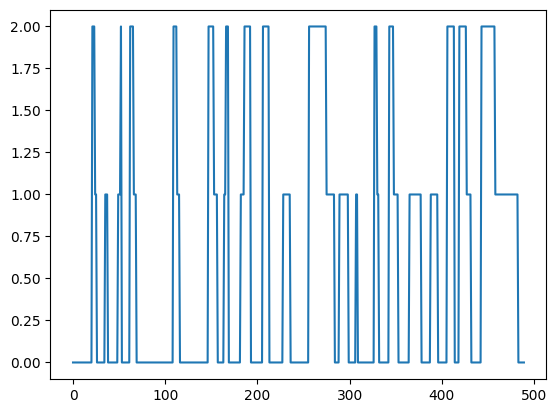

In [89]:
i = 4
plt.plot(NB_states[i*490:(i+1)*490])

In [90]:
# MAX LIFETIME
C_life = [] # state*sub
B_life = []
NB_life = []

print('Controls')
# Loop over subjects
# C_life = {0:[], 1:[], 2:[], 3:[]}# dictionary with states as key and lifetimes as values
C_life_max = {}
C_life_mean = {}
for p in range(num_states):
    C_life_max[p] = [] # dictionary with states as key and lifetimes as values
    C_life_mean[p] = [] # dictionary with states as key and lifetimes as values
for s in range(groups_num[0]):
    sub = C_states[s*time_points:(s+1)*time_points]
    prev_state = sub[0]
    cur_state = sub[0]
    life_count = 1
    # Loop over time points
    lifes = {}
    for p in range(num_states):
        lifes[p]=[] # lifetime for each states for one subject
    for t in range(1,time_points):
        cur_state = sub[t]
        if cur_state == prev_state:
            life_count += 1
        elif cur_state != prev_state:
            lifes[prev_state].append(life_count)
            life_count = 1
        prev_state = cur_state
    for p in range(num_states):   
        if len(lifes[p])!=0:
            C_life_max[p].append(np.max(lifes[p]))
            C_life_mean[p].append(np.mean(lifes[p]))

print('Blindsight')
# Loop over subjects
# B_life = {0:[], 1:[], 2:[], 3:[]}# dictionary with states as key and lifetimes as values
B_life_max = {}
B_life_mean = {}
for p in range(num_states):
    B_life_max[p] = [] # dictionary with states as key and lifetimes as values
    B_life_mean[p] = [] # dictionary with states as key and lifetimes as values
for s in range(groups_num[1]):
    sub = B_states[s*time_points:(s+1)*time_points]
    prev_state = sub[0]
    cur_state = sub[0]
    life_count = 1
    # Loop over time points
    for p in range(num_states):
        lifes[p]=[]
    for t in range(1,time_points):
        cur_state = sub[t]
        if cur_state == prev_state:
            life_count += 1
        elif cur_state != prev_state:
            lifes[prev_state].append(life_count)
            life_count = 1
        prev_state = cur_state
    for p in range(num_states):   
        if len(lifes[p])!=0:
            B_life_max[p].append(np.max(lifes[p]))
            B_life_mean[p].append(np.mean(lifes[p]))

print('No-Blindsight')
# Loop over subjects
NB_life_max = {}
NB_life_mean = {}
for p in range(num_states):
    NB_life_max[p] = [] # dictionary with states as key and lifetimes as values
    NB_life_mean[p] = [] # dictionary with states as key and lifetimes as values
for s in range(groups_num[2]):
    sub = NB_states[s*time_points:(s+1)*time_points]
    prev_state = sub[0]
    cur_state = sub[0]
    life_count = 1
    # Loop over time points
    for p in range(num_states):
        lifes[p]=[]
    for t in range(1,time_points):
        cur_state = sub[t]
        if cur_state == prev_state:
            life_count += 1
        elif cur_state != prev_state:
            lifes[prev_state].append(life_count)
            life_count = 1
        prev_state = cur_state
    for p in range(num_states):
        if len(lifes[p])!=0:
            NB_life_max[p].append(np.max(lifes[p]))
            NB_life_mean[p].append(np.mean(lifes[p]))
print('\n')

Controls
Blindsight
No-Blindsight




In [94]:
from statannot import add_stat_annotation

STATES MAX LIFETIME
STATE  1
Ttest_indResult(statistic=0.12454546593142257, pvalue=0.9018413417040649)
Ttest_indResult(statistic=1.061883983664913, pvalue=0.2993117348201574)
Ttest_indResult(statistic=1.076156980565269, pvalue=0.296893117629724)


STATE  2
Ttest_indResult(statistic=-0.8239717784513223, pvalue=0.4174504248968218)
Ttest_indResult(statistic=-0.8307282450196924, pvalue=0.4146679088257298)
Ttest_indResult(statistic=0.09584355301354851, pvalue=0.9247655924408984)


STATE  3
Ttest_indResult(statistic=0.3271199175863834, pvalue=0.7461963349994503)
Ttest_indResult(statistic=-1.1754526475907214, pvalue=0.2518387595217639)
Ttest_indResult(statistic=-1.180743618158633, pvalue=0.2539616310446969)


STATES MEAN LIFETIME
STATE  1
Ttest_indResult(statistic=0.03932388176622545, pvalue=0.968932569025134)
Ttest_indResult(statistic=0.2982320125454413, pvalue=0.7682036841417563)
Ttest_indResult(statistic=0.2802629044161001, pvalue=0.7826576955117349)


STATE  2
Ttest_indResult(statistic=-0

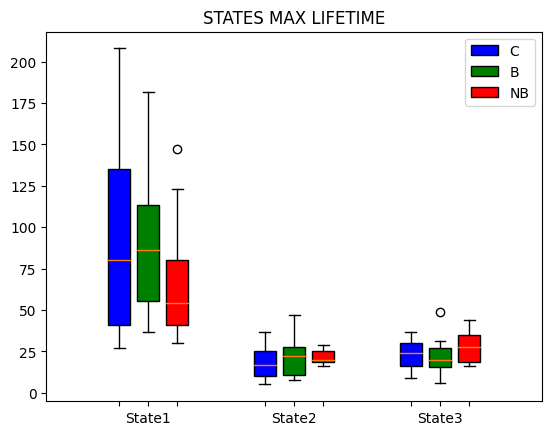

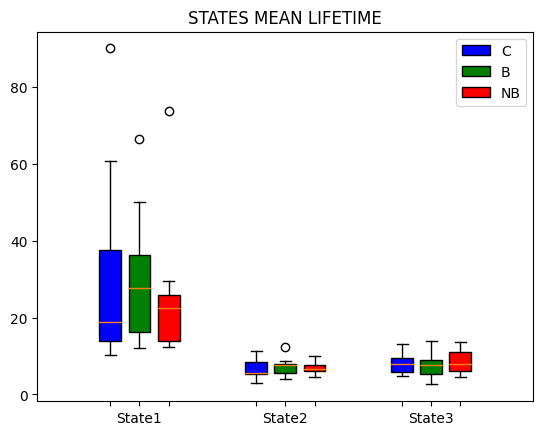

In [95]:
eps = 0.2
fig = plt.figure()
print('STATES MAX LIFETIME')
plt.title('STATES MAX LIFETIME')
for i in range(num_states):
#     plt.ylim(0,1)
    bp = plt.boxplot([C_life_max[i], B_life_max[i], NB_life_max[i]], positions = [i-eps, i, i+eps],
                     patch_artist=True,
                     labels=['','State'+str(i+1),''])
    bp['boxes'][0].set_facecolor('blue')
    bp['boxes'][1].set_facecolor('green')
    bp['boxes'][2].set_facecolor('red')
    
    # t-tests 
    print('STATE ', i+1)
    print(ttest_ind(C_life_max[i], B_life_max[i]))
    print(ttest_ind(C_life_max[i], NB_life_max[i]))
    print(ttest_ind(B_life_max[i], NB_life_max[i]))
    print('\n')

plt.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], ['C', 'B', 'NB'], loc='upper right')

fig = plt.figure()
plt.title('STATES MEAN LIFETIME')
print('STATES MEAN LIFETIME')
for i in range(num_states):
#     plt.ylim(0,1)
    bp = plt.boxplot([C_life_mean[i], B_life_mean[i], NB_life_mean[i]], positions = [i-eps, i, i+eps],
                     patch_artist=True,
                     labels=['','State'+str(i+1),''])
    bp['boxes'][0].set_facecolor('blue')
    bp['boxes'][1].set_facecolor('green')
    bp['boxes'][2].set_facecolor('red')
    
    # t-tests 
    print('STATE ', i+1)
    print(ttest_ind(C_life_mean[i], B_life_mean[i]))
    print(ttest_ind(C_life_mean[i], NB_life_mean[i]))
    print(ttest_ind(B_life_mean[i], NB_life_mean[i]))
    print('\n')

plt.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], ['C', 'B', 'NB'], loc='upper right')

STATE  1
Ttest_indResult(statistic=-0.3524184707062004, pvalue=0.727365232946771)
Ttest_indResult(statistic=-0.23857136351380354, pvalue=0.8135507896225039)
Ttest_indResult(statistic=0.09459915572863777, pvalue=0.9257393075582885)


STATE  2
Ttest_indResult(statistic=-0.37567350927618154, pvalue=0.7102073280349598)
Ttest_indResult(statistic=-0.0465480250514026, pvalue=0.9632752717583798)
Ttest_indResult(statistic=0.30196431552401315, pvalue=0.7663422015495098)


STATE  3
Ttest_indResult(statistic=1.014758705980233, pvalue=0.31957153690973067)
Ttest_indResult(statistic=0.4101648132612253, pvalue=0.6854806388082852)
Ttest_indResult(statistic=-0.468620124959132, pvalue=0.6452941213023726)




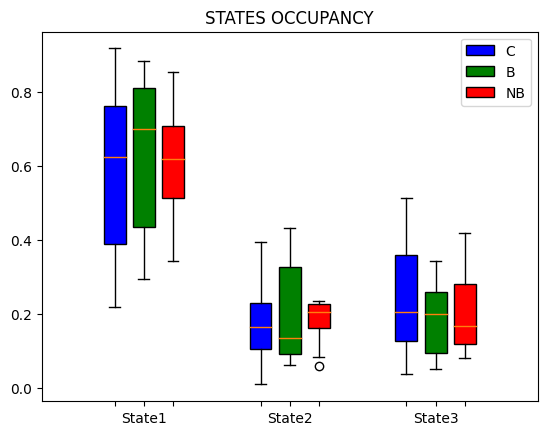

In [96]:
# OCCUPANCY
eps = 0.2
fig = plt.figure()
plt.title('STATES OCCUPANCY')
for i in range(num_states):
#     plt.ylim(0,1)
    bp = plt.boxplot([C_occup[i], B_occup[i], NB_occup[i]], 
                     positions = [i-eps, i, i+eps],
                     labels=['','State'+str(i+1),''],
                     patch_artist=True)
    bp['boxes'][0].set_facecolor('blue')
    bp['boxes'][1].set_facecolor('green')
    bp['boxes'][2].set_facecolor('red')
    
    # t-tests 
    print('STATE ', i+1)
    print(ttest_ind(C_occup[i], B_occup[i]))
    print(ttest_ind(C_occup[i], NB_occup[i]))
    print(ttest_ind(B_occup[i], NB_occup[i]))
    print('\n')
    
plt.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], ['C', 'B', 'NB'], loc='upper right')

## 6 - Evaluate transition probability between states

17
11
8
17
11
8
9753


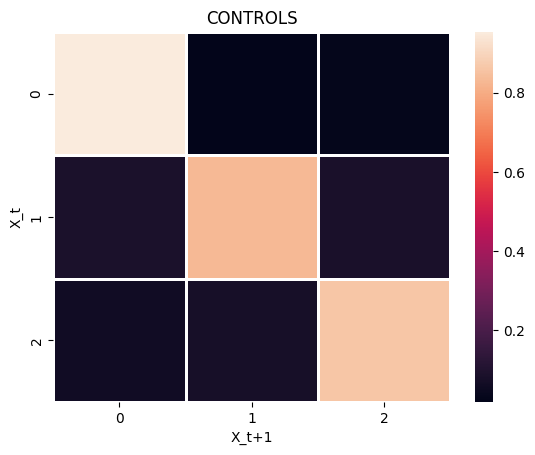

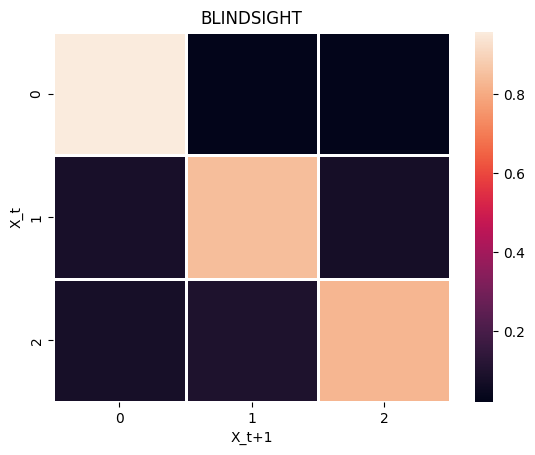

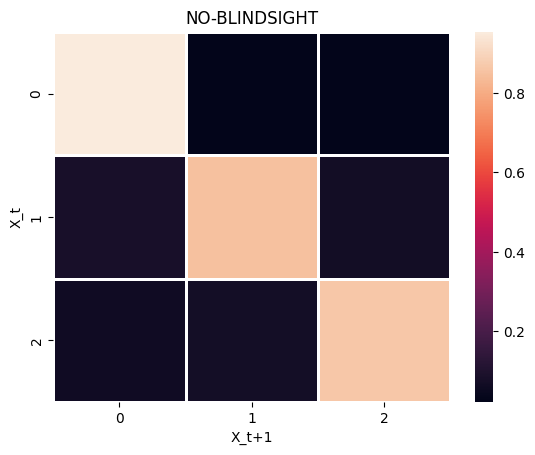

In [99]:
#############
## FORWARD ##
#############


# COUNT THE TRANSITION BETWEEN EACH COUPLE OF STATES
# subject-by-subject
C = int(np.sum(group_labels==0)/490)
B = int(np.sum(group_labels==1)/490)
NB = int(np.sum(group_labels==2)/490)
groups = [C_states, B_states, NB_states]
groups_num = [C, B, NB]

tot = []
prob_trans_list = [] # I save all the prob transition matrices of each subject of each group in a list
for g, g_num in zip(groups, groups_num):
    print(g_num)
    matrices = np.empty((0, num_states, num_states))
    # Loop over subjects
    to = 0
    for s in range(g_num):
        matrix = np.zeros((num_states, num_states))
        # count the number of transition within each possible couple of states
        prev = int(g[s*time_points])
        for t, tp in enumerate(g[(s*time_points)+1:(s+1)*time_points]):
            tp = int(tp)
            matrix[prev, tp] += 1
            if prev!=tp:
                to += 1 # total number of transitions between different states
            prev = tp
        tot.append(to)
        # matrix normalization to obtain probabilities
        for r,row in enumerate(matrix):
            matrix[r] = matrix[r]/row.sum()
#             matrix[r] = matrix[r]
        # Check nan values
        if np.isnan(matrix).any():
            iid = np.where(np.isnan(matrix))
            matrix[iid] = 0
        matrix = np.expand_dims(matrix, axis=0)
        matrices = np.concatenate((matrices, matrix))
#         print(matrices.shape)
    prob_trans_list.append(matrices)
    
##############
## BACKWARD ##
##############

# COUNT THE TRANSITION BETWEEN EACH COUPLE OF STATES
# subject-by-subject
C = int(np.sum(group_labels==0)/490)
B = int(np.sum(group_labels==1)/490)
NB = int(np.sum(group_labels==2)/490)
groups = [C_states, B_states, NB_states]
groups_num = [C, B, NB]

prob_trans_list_back = [] # I save all the prob transition matrices of each subject of each group in a list
for g, g_num in zip(groups, groups_num):
    print(g_num)
    matrices = np.empty((0, num_states, num_states))
    # Loop over subjects
    for s in range(g_num):
        matrix = np.zeros((num_states, num_states))
        # count the number of transition within each possible couple of states
        sub = g[(s*time_points):(s+1)*time_points]
        sub_rev = sub[::-1]
        prev = int(sub_rev[0])
        for t, tp in enumerate(sub_rev[1:]):
            tp = int(tp)
            matrix[prev, tp] += 1
            prev = tp
        # matrix  normalization to obtain probabilities
        for r,row in enumerate(matrix):
            matrix[r] = matrix[r]/row.sum()
#             matrix[r] = matrix[r]
        # Check nan values
        if np.isnan(matrix).any():
            iid = np.where(np.isnan(matrix))
            matrix[iid] = 0
        matrix = np.expand_dims(matrix, axis=0)
        matrices = np.concatenate((matrices, matrix))
#         print(matrices.shape)
    prob_trans_list_back.append(matrices)
    
state_names = [i for i in range(num_states)]
groups_names = ['CONTROLS', 'BLINDSIGHT', 'NO-BLINDSIGHT']
for i in range(3):
    fig = plt.figure()
    plt.title(groups_names[i])
#     sns.heatmap(np.log(prob_trans_list[i].mean(axis=0)), linewidth=0.8, xticklabels=state_names, yticklabels=state_names)
    sns.heatmap(prob_trans_list[i].mean(axis=0), linewidth=0.8, xticklabels=state_names, yticklabels=state_names)
    plt.xlabel('X_t+1')
    plt.ylabel('X_t')
    
# for i in range(3):
#     fig, ax = plt.subplots()
#     plt.title(groups_names[i])
#     im = sns.heatmap(prob_trans_list[i].mean(axis=0), linewidth=0.8, xticklabels=state_names,
#                      yticklabels=state_names, ax=ax)
#     for k in range(num_states):
#         for j in range(num_states):
#             val = prob_trans_list[i].mean(axis=0)[k,j]
#             print(val)
#             text = ax.text(j, k, val,
#                            ha="center", va="center", color="w")
    
#     plt.ylabel('X_t')

print(np.sum(tot))

Ttest_indResult(statistic=0.6282055028265143, pvalue=0.5353490950457193)
Ttest_indResult(statistic=0.5956328283371393, pvalue=0.5572368702803161)
Ttest_indResult(statistic=0.107603431109477, pvalue=0.9155700187005572)


Ttest_indResult(statistic=0.6721062195489292, pvalue=0.5074451774292701)
Ttest_indResult(statistic=0.5685553184561445, pvalue=0.5751679096343901)
Ttest_indResult(statistic=-0.02609525510927463, pvalue=0.9794852415878367)


Ttest_indResult(statistic=1.1798025419838614, pvalue=0.24876145263859428)
Ttest_indResult(statistic=0.46502481581801836, pvalue=0.6462863397793088)
Ttest_indResult(statistic=-1.2238577374160686, pvalue=0.23769806106311633)




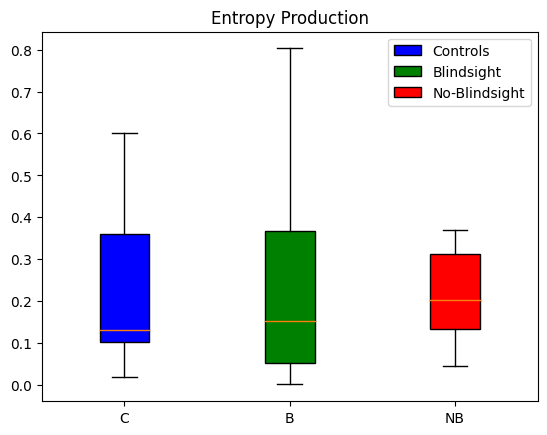

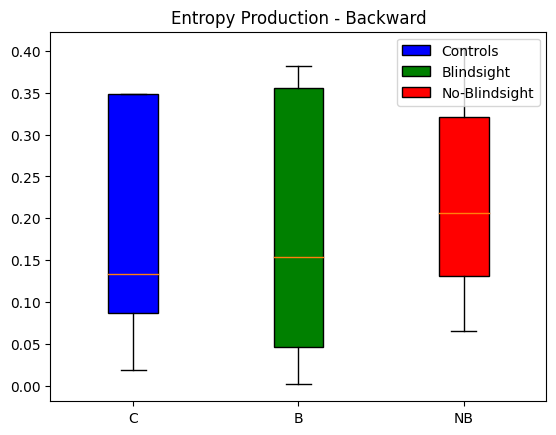

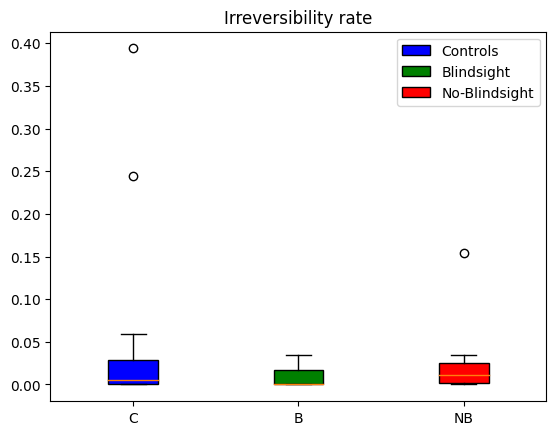

In [100]:
# COMPUTE ENTROPY PRODUCTION


#############
## FORWARD ##
#############

# Controls , Blindsight, No-blindsight
eps = 0.00000000001
Ss_for = []
for ms in prob_trans_list:
    S = []
    for m in ms:
        m = m+eps
        s = 0
        for i in range(m.shape[0]):
            for j in range(m.shape[1]):
                if i!=j: # Remove loop transition when compute transition probability
                    s_ = m[i,j]*np.log(m[i,j]/m[j,i])
                    s += s_
#         print(s)
        S.append(s)
    Ss_for.append(S)
    
fig = plt.figure()
plt.title('Entropy Production')
bp = plt.boxplot(Ss_for,
                 patch_artist=True,
                 labels=['C', 'B', 'NB'],
                 showfliers=False)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('green')
bp['boxes'][2].set_facecolor('red')

# t-tests 
print(ttest_ind(Ss_for[0], Ss_for[1]))
print(ttest_ind(Ss_for[0], Ss_for[2]))
print(ttest_ind(Ss_for[1], Ss_for[2]))
print('\n')
    
plt.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], 
           ['Controls','Blindsight','No-Blindsight'], 
           loc='upper right')

##############
## BACKWARD ##
##############

# Controls , Blindsight, No-blindsight
eps = 0.00000000001
Ss_back = []
for ms in prob_trans_list_back:
    S = []
    for m in ms:
        m = m+eps
        s = 0
        for i in range(m.shape[0]):
            for j in range(m.shape[1]):
                if i!=j: # Remove loop transition when compute transition probability
                    s_ = m[i,j]*np.log(m[i,j]/m[j,i])
                    s += s_
#         print(s)
        S.append(s)
    Ss_back.append(S)
    
fig = plt.figure()
plt.title('Entropy Production - Backward')
bp = plt.boxplot(Ss_back,
                 patch_artist=True,
                 labels=['C', 'B', 'NB'],
                 showfliers=False)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('green')
bp['boxes'][2].set_facecolor('red')

# t-tests 
print(ttest_ind(Ss_back[0], Ss_back[1]))
print(ttest_ind(Ss_back[0], Ss_back[2]))
print(ttest_ind(Ss_back[1], Ss_back[2]))
print('\n')
    
plt.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], 
           ['Controls','Blindsight','No-Blindsight'], 
           loc='upper right')


# Subject-wise different between entropy productions
#Loop over groups
Ss_diff = []
for i in range(len(Ss_for)):
    group = []
    for f,b in zip(Ss_for[i],Ss_back[i]):
        group.append(np.abs(f-b))
    Ss_diff.append(group)

fig = plt.figure()
plt.title('Irreversibility rate')
bp = plt.boxplot(Ss_diff,
                 patch_artist=True,
                 labels=['C', 'B', 'NB'])
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('green')
bp['boxes'][2].set_facecolor('red')

# t-tests 
print(ttest_ind(Ss_diff[0], Ss_diff[1]))
print(ttest_ind(Ss_diff[0], Ss_diff[2]))
print(ttest_ind(Ss_diff[1], Ss_diff[2]))
print('\n')
    
plt.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], 
           ['Controls','Blindsight','No-Blindsight'], 
           loc='upper right')

## CORRELATION WITH BEHAVIORAL DATA

In [110]:
! pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 8.9 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 3.4 MB/s eta 0:00:00a 0:00:01


In [111]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

[[-0.00027094]]
PEARSON PearsonRResult(statistic=-0.016675602348579992, pvalue=0.9459791791724553)


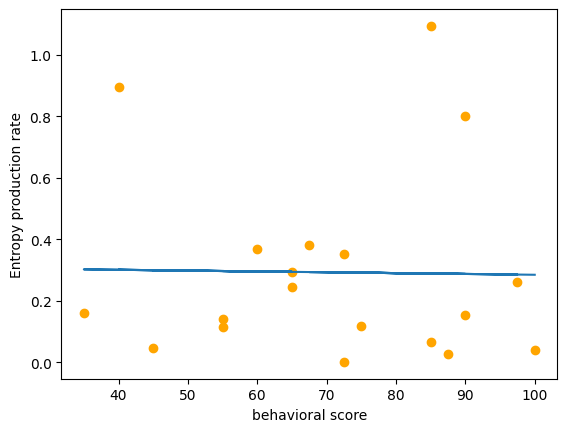

In [106]:
# PLOT ENTROPY PRODUCTION RATE WITH RESPECT TO BEAHVIORAL DATA
# Load beahvioral data
B_behav = []
NB_behav = []

class_vals = classif['CLASS'].values
Behav = classif['CLASS'].values

res = classif['Average % correct task'].values[:19]
res = [float(r) for r in res]
for i,r in enumerate(res):
    if class_vals[i]=='B': 
        B_behav.append(r)
    elif class_vals[i]=='NB':
        NB_behav.append(r)

behav = []
behav.append(B_behav)
behav.append(NB_behav)


fig = plt.figure()
behavs = behav[0] + behav[1]
Ss = []
for i,S in enumerate(Ss_for[1:]):
    plt.xlabel('behavioral score')
    plt.ylabel('Entropy production rate')
    Ss = Ss + S
    plt.scatter(behav[i], S, color='orange')
# plt.grid();

# Linear regresison
# reg = sm.OLS(behavs, Ss)
# reg_fit = reg.fit(behavs, Ss)
# p_values = reg_fit.summary2().tables[1]['P>|t|']
# # print(reg_fit.summary2())
# print(p_values)

regressor = LinearRegression() 
regressor.fit(np.asarray(behavs).reshape(-1, 1), np.asarray(Ss).reshape(-1, 1))
y_pred = regressor.predict(np.asarray(behavs).reshape(-1, 1))
plt.plot(behavs, y_pred[:,0])
print(regressor.coef_)
print('PEARSON', pearsonr(behavs, Ss))

# print(np.asarray(behavs).reshape(-1, 1).shape, behavs)

# PLOT LIFETIME WITH RESPECT TO BEAHVIORAL DATA


(19, 3, 3)


<AxesSubplot: >

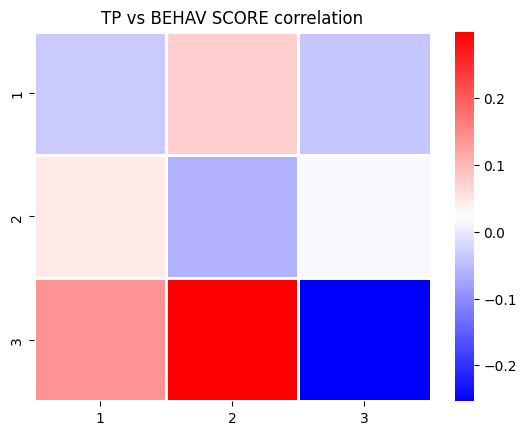

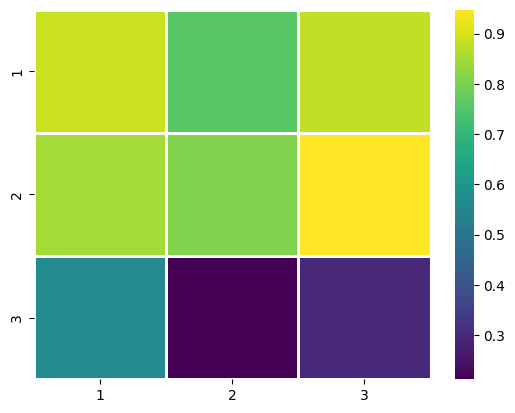

In [108]:
# TRANSITION PROBABILITIES with respect to behavioral data

state_names = [1,2,3]

pat_prob_trans = np.concatenate((prob_trans_list[1], prob_trans_list[2])) # Only patients, no controls
print(pat_prob_trans.shape)

corr_matrix = np.zeros(pat_prob_trans.shape[1:])
p_matrix = np.zeros(pat_prob_trans.shape[1:])
x = B_behav + NB_behav
# fig = plt.figure()
# plt.title('')
for i in range(num_states):
    for j in range(num_states):
        y = pat_prob_trans[:,i,j]
#         plt.scatter(x, y)
#         plt.xlabel('behavioral score')
#         plt.ylabel('Transition Probability')
#         # LINEAR REGRESSION
#         reg = sm.OLS(x, y)
#         reg_fit = reg.fit()
#         p_value = reg_fit.summary2().tables[1]['P>|t|']
        
#         regressor = LinearRegression() 
#         regressor.fit(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))
#         y_pred = regressor.predict(np.asarray(x).reshape(-1, 1))
#         corr_matrix[i,j] = regressor.coef_

        # PEARSON CORRELATION
#         print(x)
#         print(pearsonr(x,y))
#         if pearsonr(x,y)[1]<=0.05:
        corr_matrix[i,j] = pearsonr(x,y)[0]
        p_matrix[i,j] = pearsonr(x,y)[1]

#         plt.plot(x, y_pred[:,0], color=colors[i], label='State '+str(i+1))
#         print(p_value)
#         print(regressor.coef_)
#         print('\n')
fig = plt.figure()
plt.title('TP vs BEHAV SCORE correlation')
#     sns.heatmap(np.log(prob_trans_list[i].mean(axis=0)), linewidth=0.8, xticklabels=state_names, yticklabels=state_names)
sns.heatmap(corr_matrix, linewidth=0.8, xticklabels=state_names, yticklabels=state_names, cmap='bwr');
fig = plt.figure()
sns.heatmap(p_matrix, linewidth=0.8, xticklabels=state_names, yticklabels=state_names, cmap='viridis')

STATE  1
x1    6.674385e-07
Name: P>|t|, dtype: float64
[[0.37050553]]
PEARSON  state  1 PearsonRResult(statistic=0.1542357560241809, pvalue=0.5284022661952082)


STATE  2
x1    6.876836e-08
Name: P>|t|, dtype: float64
[[0.06397447]]
PEARSON  state  2 PearsonRResult(statistic=0.1266159492432613, pvalue=0.6054880267976712)


STATE  3
x1    0.000004
Name: P>|t|, dtype: float64
[[-0.23713232]]
PEARSON  state  3 PearsonRResult(statistic=-0.39281901670573005, pvalue=0.09617756352795638)




/home/alessio/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/alessio/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/alessio/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


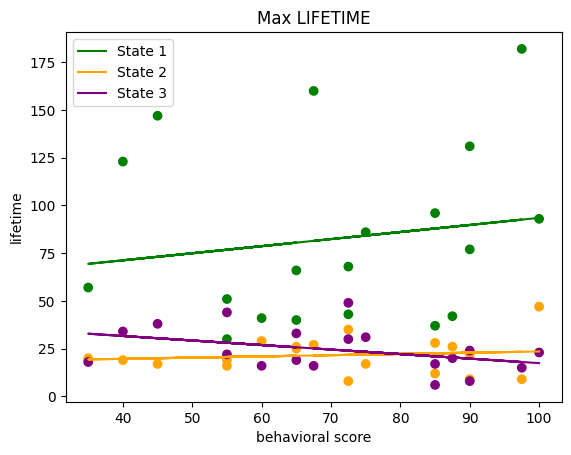

In [112]:
# LIFETIME with respect to behavioral data
# Loop over states
colors = ['green', 'orange', 'purple', 'grey']
x = B_behav + NB_behav
fig = plt.figure()
plt.title('Max LIFETIME')
for i in range(num_states):
    y = B_life_max[i] + NB_life_max[i]
    plt.scatter(x, y, c=[colors[i] for _ in range(len(y))])
    plt.xlabel('behavioral score')
    plt.ylabel('lifetime')
    
    # Linear regresison
    reg = sm.OLS(x, y)
    reg_fit = reg.fit()
    p_values = reg_fit.summary2().tables[1]['P>|t|']
    # print(reg_fit.summary2())

    regressor = LinearRegression() 
    regressor.fit(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))
    y_pred = regressor.predict(np.asarray(x).reshape(-1, 1))
    plt.plot(x, y_pred[:,0], color=colors[i], label='State '+str(i+1))
    print('STATE ', str(i+1))
    print(p_values)
    print(regressor.coef_)
    print('PEARSON  state ' , i+1, pearsonr(x, y))
    print('\n')
plt.legend()



STATE  1
x1    6.950007e-09
Name: P>|t|, dtype: float64
[[-0.00010142]]
PEARSON  state  1 PearsonRResult(statistic=-0.009937316127379404, pvalue=0.9677935094723424)


STATE  2
x1    0.000001
Name: P>|t|, dtype: float64
[[0.00079016]]
PEARSON  state  2 PearsonRResult(statistic=0.13712413920101446, pvalue=0.575624179911298)


STATE  3
x1    0.000005
Name: P>|t|, dtype: float64
[[-0.00068874]]
PEARSON  state  3 PearsonRResult(statistic=-0.1187481951751449, pvalue=0.6282506364481223)




/home/alessio/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/alessio/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/alessio/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


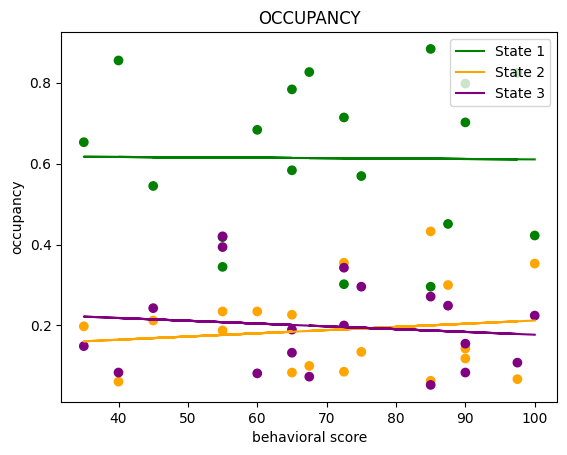

In [113]:
# OCCUPANCY with respect to behavioral data
# Loop over states
colors = ['green', 'orange', 'purple', 'grey']
x = B_behav + NB_behav
fig = plt.figure()
plt.title('OCCUPANCY')
for i in range(num_states):
    y = B_occup[i] + NB_occup[i]
    plt.scatter(x, y, c=[colors[i] for _ in range(len(y))])
    plt.xlabel('behavioral score')
    plt.ylabel('occupancy')
    
    # Linear regresison
    reg = sm.OLS(x, y)
    reg_fit = reg.fit()
    p_values = reg_fit.summary2().tables[1]['P>|t|']
    # print(reg_fit.summary2())

    regressor = LinearRegression() 
    regressor.fit(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))
    y_pred = regressor.predict(np.asarray(x).reshape(-1, 1))
    plt.plot(x, y_pred[:,0], color=colors[i], label='State '+str(i+1))
    print('STATE ', str(i+1))
    print(p_values)
    print(regressor.coef_)
    print('PEARSON  state ' , i+1, pearsonr(x, y))
    print('\n')
plt.legend(loc='upper right')

# 3.0 - CLUSTER Leading Eigenvector  GROUP-BY-GROUP

In [19]:
group_labels.shape

(17640, 1)

In [20]:
# SEPARATE THE GROUPS
V1_groups = [np.empty((0, V1.shape[-1])),
             np.empty((0, V1.shape[-1])),
             np.empty((0, V1.shape[-1]))]
# V1_groups_orig_idx = 
for i,g in enumerate(group_labels):
    if g == 0: # controls
        V1_groups[0] = np.concatenate((V1_groups[0], np.expand_dims(V1[i], axis=0)))
    elif g==1: # blindsight
        V1_groups[1] = np.concatenate((V1_groups[1], np.expand_dims(V1[i], axis=0)))
    elif g==2: # no-blindsight
        V1_groups[2] = np.concatenate((V1_groups[2], np.expand_dims(V1[i], axis=0)))
        
len(V1_groups), V1_groups[0].shape, V1_groups[1].shape, V1_groups[2].shape  

(3, (8330, 345), (5390, 345), (3920, 345))

In [21]:
# # U-MAP REPRESENTATION

# g_names = ['CONTROLS', 'BLINDSIGHT', 'NON-BLINDSIGHT']
# for idx,v1 in enumerate(V1_groups):
#     reducer = umap.UMAP(n_neighbors=15)
#     # reducer = umap.UMAP()
#     reducer.fit(V1)
#     embedding = reducer.transform(V1)
#     fig = plt.figure()
#     plt.title(g_names[idx])
#     plt.scatter(
#         embedding[:, 0],
#         embedding[:, 1],
#         alpha=0.8, s=0.1)
#     # plt.colorbar(boundaries=np.arange(n_class+1)-0.5).set_ticks(np.arange(n_class))
#     plt.gca().set_aspect('equal', 'datalim')


 # comp= 2 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 3 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 4 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 5 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 6 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 7 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 2 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 3 

2  / 15
3  / 15
4  / 15
5  / 15
6  / 15
7  / 15
8  / 15
9  / 15
10  / 15
11  / 15
12  / 15
13  / 15
14  / 15

 # comp= 4 

2 

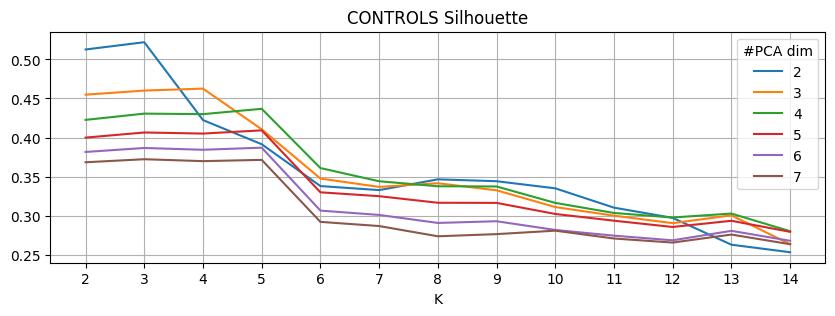

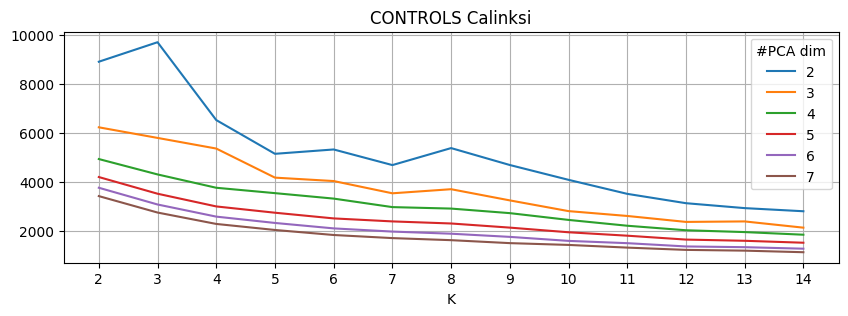

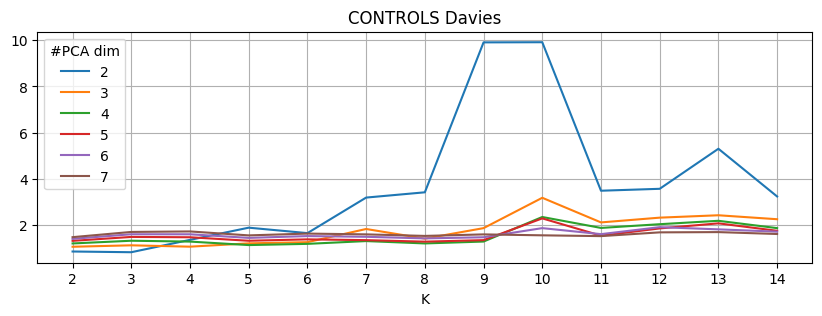

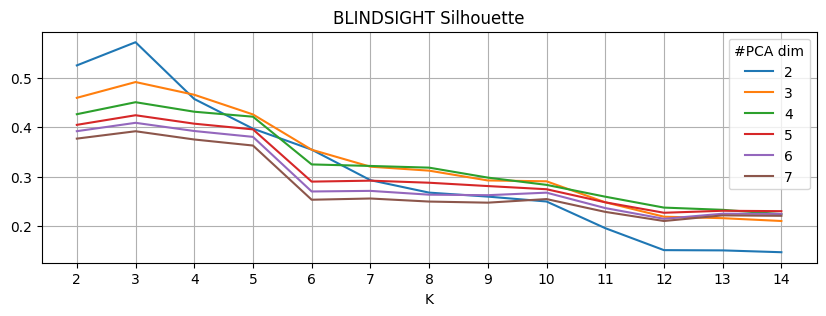

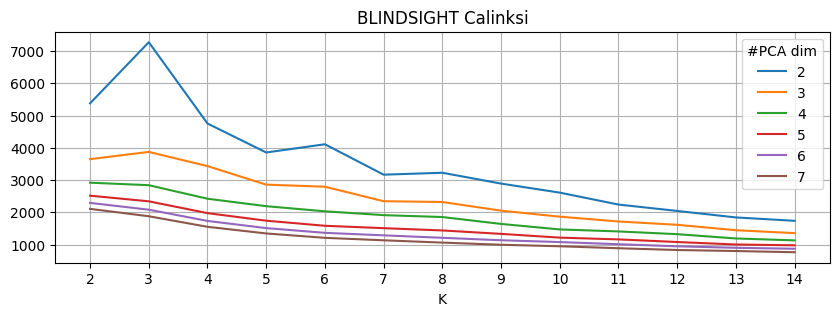

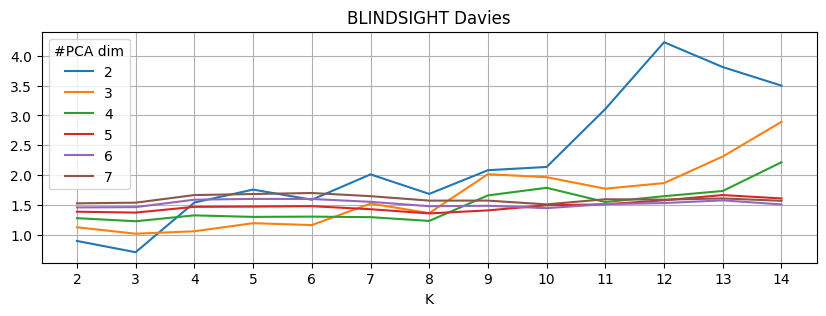

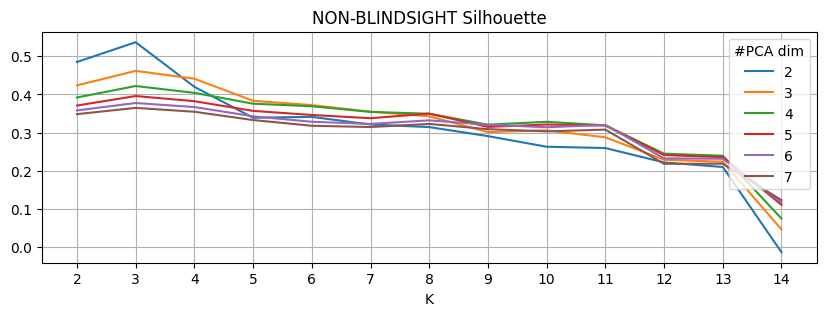

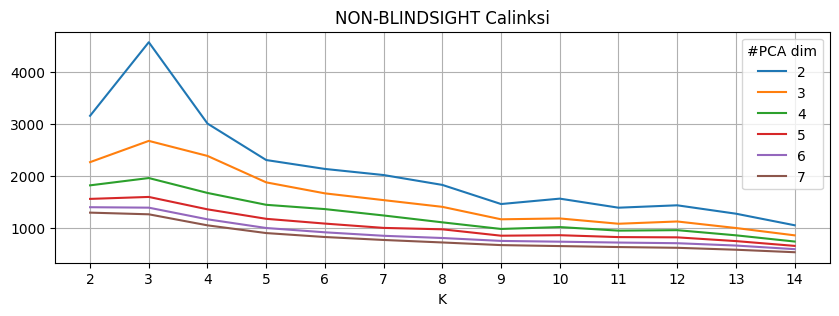

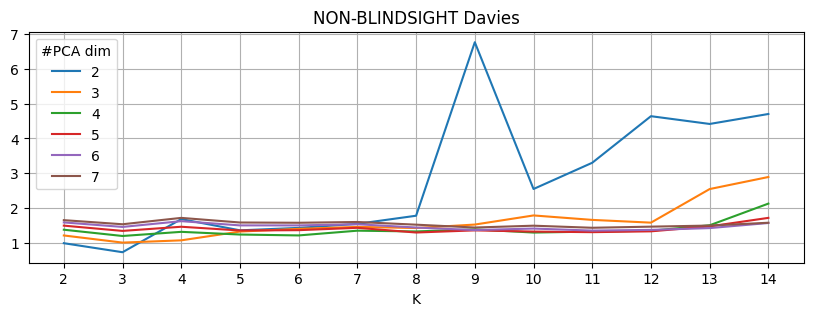

In [279]:
# K eval in PCA space

eps = 0.0001
g_names = ['CONTROLS', 'BLINDSIGHT', 'NON-BLINDSIGHT']
for idx,v1 in enumerate(V1_groups):
    
    pca = sklearn.decomposition.PCA(n_components=100)
    pca.fit(v1)
    
    v1_pca = pca.transform(v1)
    
    silhouettes = []
    calinksis = []
    daviess = []
    kss = []
    for comp in range(2,8):
        print('\n # comp=', comp, '\n')
        inertia = []
        silhouette = []
        calinksi = []
        davies = []
        bics = []
        ks = []
        gs_counts = []
        k_max = 15
        eps=0.00001
        for k in range(2, k_max):
            print(k,' /',str(k_max))
            km, i, s, c, d, b = get_km_score(k, v1, pca=True, pca_X=v1_pca[:,:comp])
            inertia.append(i)
            silhouette.append(s)
            calinksi.append(c)
            davies.append(d)
            bics.append(b)
            ks.append(k)
            clust = km.cluster_centers_
            gs_count = 0
            for s in clust:
                if np.sum(s<0+eps)==s.shape[-1]:
                    gs_count += 1
            gs_counts.append(gs_count)    

        silhouettes.append(silhouette)
        calinksis.append(calinksi)
        daviess.append(davies)
        kss.append(ks)

    fig = plt.figure(figsize=(10,3))
    plt.title(str(g_names[idx])+' Silhouette')
    plt.xlabel('K')
    for c,silhouette in enumerate(silhouettes):
        plt.plot(ks, silhouette, label=str(c+2))
    plt.xticks([t for t in range(2,15)])
    plt.grid()
    plt.legend(title='#PCA dim')

    fig = plt.figure(figsize=(10,3))
    plt.title(str(g_names[idx])+' Calinksi')
    plt.xlabel('K')
    for c,calinksi in enumerate(calinksis):
        plt.plot(ks, calinksi, label=str(c+2))
    plt.xticks([t for t in range(2,15)])
    plt.grid()
    plt.legend(title='#PCA dim')

    fig = plt.figure(figsize=(10,3))
    plt.title(str(g_names[idx])+' Davies')
    plt.xlabel('K')
    for c,davies in enumerate(daviess):
        plt.plot(ks, davies, label=str(c+2))
    plt.xticks([t for t in range(2,15)])
    plt.grid()
    plt.legend(title='#PCA dim')

    # fig = plt.figure(figsize=(5,3))
    # plt.title('Inertia')
    # plt.plot(ks, inertia)

    # fig = plt.figure(figsize=(5,3))
    # plt.title('BIC')
    # plt.plot(ks, bics)

    # fig = plt.figure(figsize=(5,3))
    # plt.title('# of Global States')
    # plt.plot(ks, gs_counts)

In [ ]:
# Loop over groups
eps = 0.0001
g_names = ['CONTROLS', 'BLINDSIGHT', 'NON-BLINDSIGHT']
for idx,v1 in enumerate(V1_groups):

    inertia = []
    silhouette = []
    calinksi = []
    davies = []
    bics = []
    ks = []
    gs_counts = []
    k_max = 200
    for k in range(2, k_max):
        print(k,' /',str(k_max))
        km, i, s, c, d, b = get_km_score(k, v1)
        inertia.append(i)
        silhouette.append(s)
        calinksi.append(c)
        davies.append(d)
        bics.append(b)
        ks.append(k)
        clust = km.cluster_centers_
        gs_count = 0
        for s in clust:
            if np.sum(s<0+eps)==s.shape[-1]:
                gs_count += 1
        gs_counts.append(gs_count)    
        
    fig = plt.figure(figsize=(5,3))
    plt.title(str(g_names[idx])+' Silhouette')
    plt.plot(ks, silhouette)

    fig = plt.figure(figsize=(5,3))
    plt.title(str(g_names[idx])+' Calinksi')
    plt.plot(ks, calinksi)

    fig = plt.figure(figsize=(5,3))
    plt.title(str(g_names[idx])+' Davies')
    plt.plot(ks, davies)

    fig = plt.figure(figsize=(5,3))
    plt.title(str(g_names[idx])+' Inertia')
    plt.plot(ks, inertia)

    fig = plt.figure(figsize=(5,3))
    plt.title(str(g_names[idx])+' BIC')
    plt.plot(ks, bics)
    
    fig = plt.figure(figsize=(5,3))
    plt.title(str(g_names[idx])+'# of Global States')
    plt.plot(ks, gs_counts)

## 3.1 - K-MEANS

In [22]:
# METHODS FOR K-MEANS COMPUTING AND SCORING

def get_km_score(k, X):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    labels = km.predict(X)
    inertia = km.inertia_
    silhouette = silhouette_score(X, labels)
    calinksi = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    bic = compute_bic(km, X)
    return km, inertia, silhouette, calinksi, davies, bic

def get_km_centr_label(k, X):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    centr = km.cluster_centers_
    labels = km.predict(X)
    return km, centr, labels

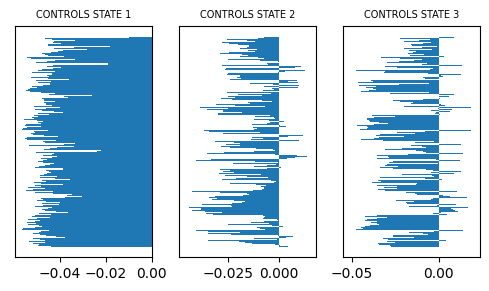

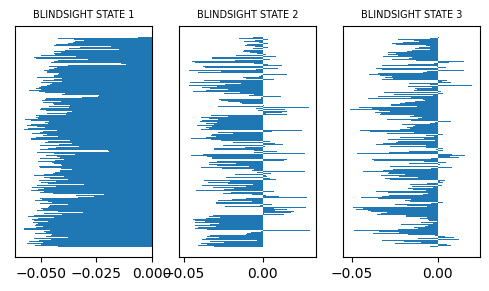

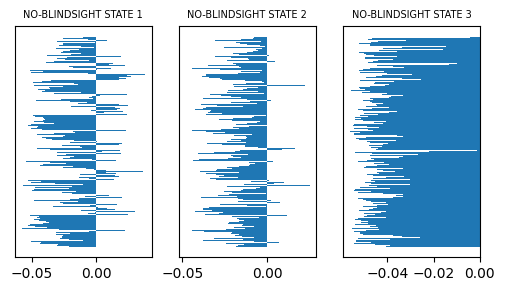

In [23]:
# LOOP OVER GROUPS
g_names = ['CONTROLS', 'BLINDSIGHT', 'NO-BLINDSIGHT']
g_states = [] # Lists collecting the states of the three groups
g_state_labels = []
for idx,v1 in enumerate(V1_groups):
    # GET STATE OF BELONGING FOR EACH EIGENVECTOR
    num_states = 3
    # num_states = 5 # For whole brain
    # num_states = 8 # For interesting nodes
    _, states, state_labels = get_km_centr_label(num_states, v1)
    g_states.append(states)
    g_state_labels.append(state_labels)
#     print(state_labels.shape)

    # PLOT CENTROIDS
    fig,axs = plt.subplots(1,num_states, figsize=(6,3))
    for i in range(num_states):
        axs[i].set_title(g_names[idx]+' STATE {}' .format(i+1), fontsize=7)
        axs[i].barh(range(states[i].shape[0]), states[i], height=1)
        axs[i].set_yticks([])
    #              tick_label=nodes_labels)

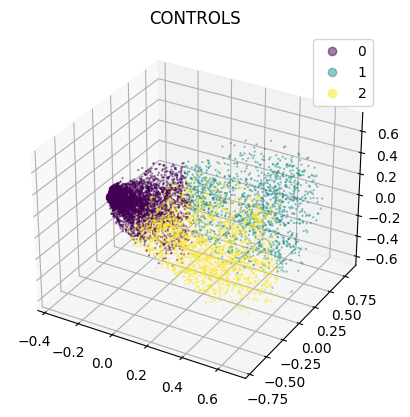

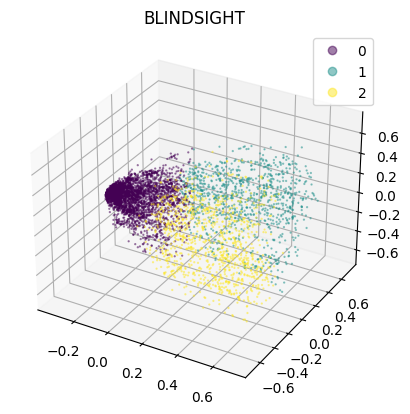

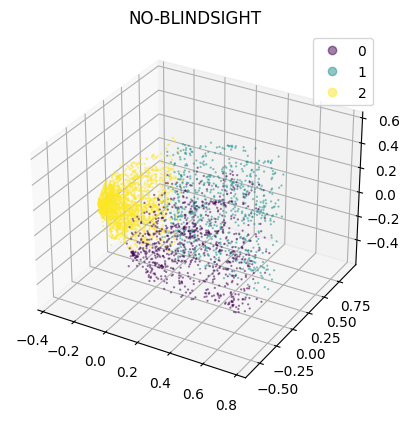

In [319]:
for idx,v1 in enumerate(V1_groups):
    pca = sklearn.decomposition.PCA(n_components=100)
    pca.fit(v1)
    v1_pca = pca.transform(v1)
    fig  = plt.figure()
    ax = plt.axes(projection='3d')
    scat = ax.scatter3D(v1_pca[:,0], v1_pca[:,1], v1_pca[:,2], c = g_state_labels[idx], s=0.4, alpha=0.5)
    # scat = ax.scatter3D(V1_pca[:,0], V1_pca[:,1], V1_pca[:,2], c = group_labels, s=0.4, alpha=0.5)
    plt.title(groups_names[idx])
    plt.legend(*scat.legend_elements())

In [ ]:
# # SAVE CENTROIDS AS BRAIN MAPS

# today = date.today()
# DATE = today.strftime("%d%m%Y")
# print(DATE)

# # Loop over centroids
# for state in states:
#     brain_map = np.empty(atlas.shape)
#     # Loop over centroids
#     for i,roi_val in enumerate(state)
#         mask = np.where(atlas==(i+1))
#         brain_map[mask] = roi_val
#     nii_img=nib.Nifti1Image(new_image_frequency_nobroad_high, data_affine, data_header)
#     nib.save(nii_img, '/output/centroids/HMM/KMEANScentroids_k'+str(num_states)+'_'+str(DATE)+'.nii.gz')
#     nib.save()

# 3.2 - COMPUTE SIMILARITIES BETWEEN THE STATES OF THE THREE GROUPS

In [320]:
# # DATA NORMALIZATION
# X = np.concatenate((GS_state_C, GS_state_B, GS_state_NB))
# std = X.std(axis=0)
# mean = X.mean(axis=0)
# maxx = np.abs(X).max(axis=0)
# X_new = np.empty((0,394))
# for x in X:
#     X_new = np.concatenate((X_new, np.expand_dims(np.divide(x,maxx), axis=0)), axis=0)
# X_norm = X_new
# # X_norm = (X - mean)/std
# plt.barh(range(X_norm.shape[1]), X_norm[0])

### 3.2.1 - Compute similarities between GLOBAL SIGNAL CENTROIDS

(345,)
(345,)
(345,)
pino
pino
pino


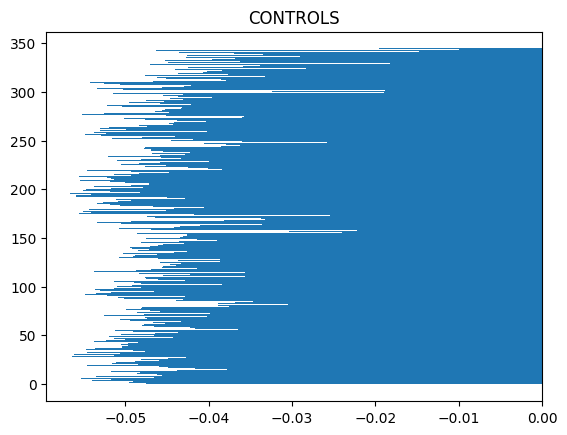

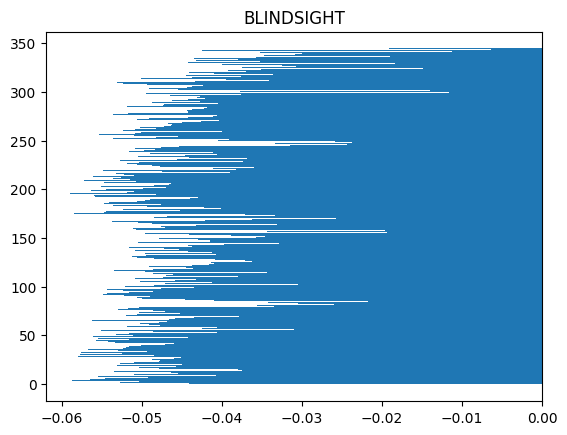

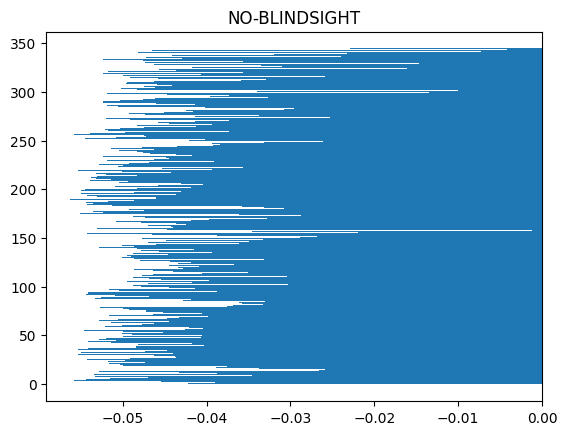

In [24]:
# At first I have the find the GLOBAL SIGNAL state of the three groups, it's the one with only negative components
eps = 0.0001
not_GS_states = []
GS_states = []
GS_states_idx = [] # which state is the global state
not_GS_states_idx = []
for g in g_states: # controls, blindsight, non-blindsight
    l = [] 
    l_idx = []
    # loop over states
    for i,s in enumerate(g):
        
        # Loop over components
        if np.sum(s<0+eps)==s.shape[0]:
            print(s.shape)
            GS_states_idx.append(i)
            GS_states.append(s)
        else:
            l_idx.append(i)
            l.append(s)
    not_GS_states_idx.append(l_idx)
    not_GS_states.append(l)
    
for idx,gs in enumerate(GS_states):
    print('pino')
    fig = plt.figure()
    plt.title(g_names[idx])
    plt.barh(range(gs.shape[0]), gs, height=1)
#              tick_label=nodes_labels)

(345,)
[[1.]]
[[0.99689758]]
[[0.99442983]]
(345,)
[[0.99689758]]
[[1.]]
[[0.99368872]]
(345,)
[[0.99442983]]
[[0.99368872]]
[[1.]]


<AxesSubplot:title={'center':'EUCLIDEAN DISTANCE'}>

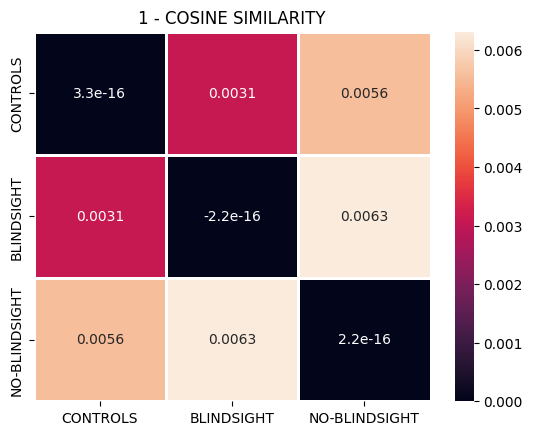

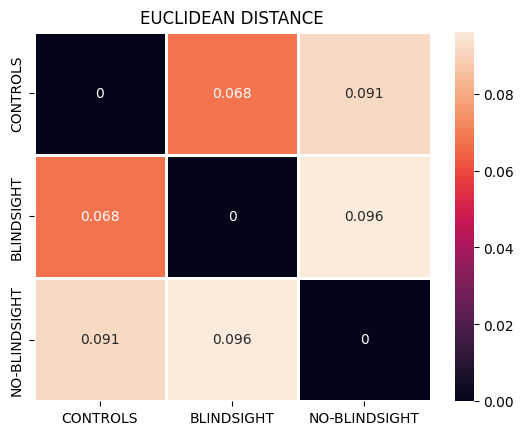

In [25]:
# Similarity matrix between the global signal state of the three groups
val_min = 0.99
cosine_matrix = np.zeros((len(GS_states), len(GS_states)))
euclidean_matrix = np.zeros((len(GS_states), len(GS_states)))
for i,g_i in enumerate(GS_states):
    print(g_i.shape)
    for j,g_j in enumerate(GS_states):
#         if i!=j:
        print(cosine_similarity(np.expand_dims(g_i, axis=0), np.expand_dims(g_j, axis=0)))
        cosine_matrix[i,j] = cosine_similarity(np.expand_dims(g_i, axis=0), 
                                               np.expand_dims(g_j, axis=0))
        euclidean_matrix[i, j] = euclidean(g_i, g_j)
            
val_min = 0.99
fig = plt.figure()
plt.title('1 - COSINE SIMILARITY')
sns.heatmap(1-cosine_matrix, linewidth=0.8, xticklabels=g_names, yticklabels=g_names, annot=True)

val_min=0.8
fig = plt.figure()
plt.title('EUCLIDEAN DISTANCE')
sns.heatmap(euclidean_matrix, linewidth=0.8, xticklabels=g_names, yticklabels=g_names, annot=True)

In [324]:
GS_states[0].shape

(345,)

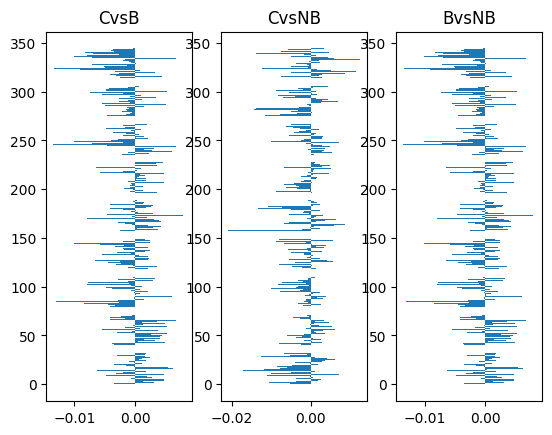

In [325]:
# Which areas involved in the global signal are the most different between groups?
num_ar = GS_states[0].shape[0]
delta_tensor = np.zeros((3, num_ar)) # CvsB, CvsNB, BvsNB
for a in range(num_ar):
#     delta_tensor[0,a] = np.abs(GS_states[0][a]-GS_states[1][a])
#     delta_tensor[1,a] = np.abs(GS_states[0][a]-GS_states[2][a])
#     delta_tensor[2,a] = np.abs(GS_states[1][a]-GS_states[2][a])
    delta_tensor[0,a] = GS_states[0][a]-GS_states[1][a]
    delta_tensor[1,a] = GS_states[0][a]-GS_states[2][a]
    delta_tensor[2,a] = GS_states[1][a]-GS_states[2][a]
    
fig, axs = plt.subplots(1,3)
axs[0].barh(range(num_ar), delta_tensor[0])
axs[0].title.set_text('CvsB')
axs[1].barh(range(num_ar), delta_tensor[1])
axs[1].title.set_text('CvsNB')
axs[2].barh(range(num_ar), delta_tensor[0])
axs[2].title.set_text('BvsNB')

In [326]:
# Which areas differs the most?
delta_areas = []
for delta in delta_tensor:
    l = []
    thresh = np.percentile(np.abs(delta),95)
    for i,a in enumerate(delta):
        if np.abs(a) > thresh:
            if a>0:
                sign = ' POS'
            else:
                sign = ' NEG'
            l.append(atlas_labels[atlas_labels['Unnamed: 0']==i]['area'].values[0] + sign)
            l.append(no_les_labels[i] + sign)
    delta_areas.append(l)

In [327]:
delta_areas

[['L_46 NEG',
  'L_11l NEG',
  'L_9-46d NEG',
  'L_OFC NEG',
  'L_52 NEG',
  'L_Pir NEG',
  'L_PFcm NEG',
  'L_AAIC NEG',
  'L_IP1 NEG',
  'L_V6A NEG',
  'L_PGs NEG',
  'L_V3CD NEG',
  'L_V6A NEG',
  'L_LO3 NEG',
  'L_p47r NEG',
  'L_PI NEG',
  'L_LBelt POS',
  'L_SC POS',
  'R_47m NEG',
  'R_10pp NEG',
  'R_9m NEG',
  'R_OFC NEG',
  'R_47s POS',
  'R_EC POS',
  'R_PreS NEG',
  'R_25 NEG',
  'R_PGp NEG',
  'L_Caud_ant NEG',
  'R_IP2 NEG',
  'L_Pall_ant NEG',
  'R_V4t NEG',
  'R_Pall_ant NEG',
  'R_FST NEG',
  'R_Put_ant NEG',
  'R_VMV2 NEG',
  'R_Caud_post NEG'],
 ['L_V6 NEG',
  'L_V4 NEG',
  'L_FEF NEG',
  'L_V3A NEG',
  'L_POS2 NEG',
  'L_V3B NEG',
  'L_V7 NEG',
  'L_LO1 NEG',
  'L_7Pm NEG',
  'L_5m NEG',
  'L_PGs NEG',
  'L_V3CD NEG',
  'L_V6A NEG',
  'L_LO3 NEG',
  'L_LO3 NEG',
  'L_pOFC NEG',
  'L_SC NEG',
  'R_LO1 NEG',
  'R_MST NEG',
  'R_MT NEG',
  'R_47s NEG',
  'R_EC NEG',
  'R_6a NEG',
  'R_STGa NEG',
  'R_OP2-3 NEG',
  'R_TGd NEG',
  'R_52 NEG',
  'R_TE1a NEG',
  'R_TPOJ3 P

In [329]:
# Collect the vectors of each subject belonging to GS state, for each group

GS_state_C = np.empty((0,345))
GS_state_B = np.empty((0,345))
GS_state_NB = np.empty((0,345))
for i in range(len(GS_states_idx)):
    idx = np.where(g_state_labels[i]==GS_states_idx[i])[0] # which eigenvectors are associated to global state
    if i==0:
        GS_state_C = V1_groups[i][idx]
    elif i==1:
        GS_state_B = V1_groups[i][idx]
    else:
        GS_state_NB = V1_groups[i][idx]
        
GS_state_C.shape, GS_state_B.shape, GS_state_NB.shape

# Collect the vectors of each subject NOT belonging to GS state, for each group

not_GS_state_C = np.empty((0,345))
not_GS_state_B = np.empty((0,345))
not_GS_state_NB = np.empty((0,345))
for i in range(len(not_GS_states_idx)):
    for idx,s in enumerate(g_state_labels[i]):
        if s in not_GS_states_idx[i]:
            if i==0:
                not_GS_state_C = np.concatenate((not_GS_state_C, np.expand_dims(V1_groups[i][idx], axis=0)))
            elif i==1:
                not_GS_state_B = np.concatenate((not_GS_state_B, np.expand_dims(V1_groups[i][idx], axis=0)))
            else:
                not_GS_state_NB = np.concatenate((not_GS_state_NB, np.expand_dims(V1_groups[i][idx], axis=0)))
        
print(GS_state_C.shape, GS_state_B.shape, GS_state_NB.shape)
print(not_GS_state_C.shape, not_GS_state_B.shape, not_GS_state_NB.shape)

(4908, 345) (3363, 345) (2381, 345)
(3422, 345) (2027, 345) (1539, 345)


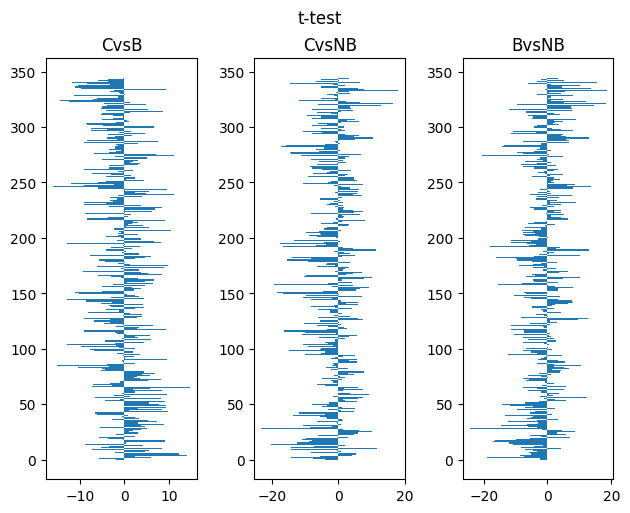

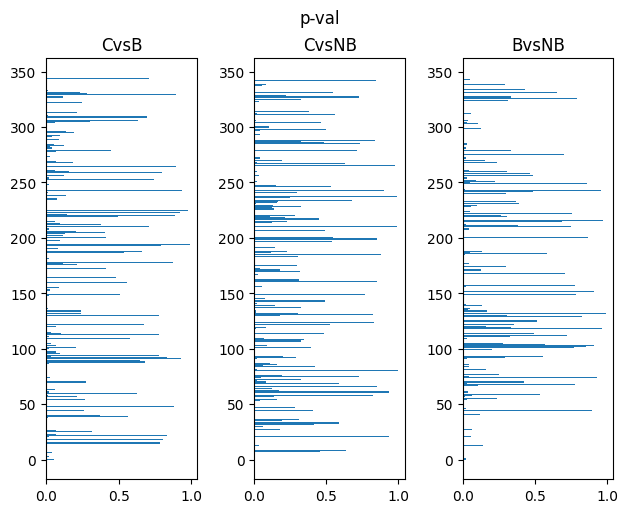

In [330]:
# I DO THE SAME AS BEFORE, BUT WITH SOME STATISTICS
# I CONSIDER ALL THE EIGENVECTORS BELONGING TO THE GS states, not only the centroid

# Which areas involved in the global signal are the most different between groups?
num_ar = GS_states[0].shape[0] # number of areas/components
delta_tensor_stat = np.zeros((3, num_ar)) # CvsB, CvsNB, BvsNB
delta_tensor_p = np.zeros((3, num_ar)) # CvsB, CvsNB, BvsNB
for a in range(num_ar):
#     delta_tensor[0,a] = np.abs(GS_states[0][a]-GS_states[1][a])
#     delta_tensor[1,a] = np.abs(GS_states[0][a]-GS_states[2][a])
#     delta_tensor[2,a] = np.abs(GS_states[1][a]-GS_states[2][a])
    delta_tensor_stat[0,a] = ttest_ind(GS_state_C[:, a],GS_state_B[:, a])[0]
    delta_tensor_stat[1,a] = ttest_ind(GS_state_C[:, a],GS_state_NB[:, a])[0]
    delta_tensor_stat[2,a] = ttest_ind(GS_state_B[:, a],GS_state_NB[:, a])[0]
    
    delta_tensor_p[0,a] = ttest_ind(GS_state_C[:, a],GS_state_B[:, a])[1]
    delta_tensor_p[1,a] = ttest_ind(GS_state_C[:, a],GS_state_NB[:, a])[1]
    delta_tensor_p[2,a] = ttest_ind(GS_state_B[:, a],GS_state_NB[:, a])[1]
    
fig, axs = plt.subplots(1,3)
fig.tight_layout()
plt.suptitle('t-test', y=1.06)
axs[0].barh(range(num_ar), delta_tensor_stat[0], height=1)
axs[0].title.set_text('CvsB')
axs[1].barh(range(num_ar), delta_tensor_stat[1], height=1)
axs[1].title.set_text('CvsNB')
axs[2].barh(range(num_ar), delta_tensor_stat[2], height=1)
axs[2].title.set_text('BvsNB')

fig, axs = plt.subplots(1,3)
fig.tight_layout()
plt.suptitle('p-val', y=1.06)
axs[0].barh(range(num_ar), delta_tensor_p[0], height=1)
axs[0].title.set_text('CvsB')
axs[1].barh(range(num_ar), delta_tensor_p[1], height=1)
axs[1].title.set_text('CvsNB')
axs[2].barh(range(num_ar), delta_tensor_p[2], height=1)
axs[2].title.set_text('BvsNB')

In [331]:
# Which areas differs the most?
delta_areas_p = []
for i,delta_p in enumerate(delta_tensor_p):
    delta_t = delta_tensor_stat[i]
    print(delta_t.shape)
    l = []
    thresh_p = 0.05/num_ar
    thresh_t = np.percentile(np.abs(delta_t), 95)
    for j,a in enumerate(delta_p):
        if a < thresh_p and delta_t[j] > thresh_t:
#             l.append(atlas_labels[atlas_labels['Unnamed: 0']==j]['area'].values[0])
            l.append(no_les_labels[j]) # If lesioned nodes are removed
    delta_areas_p.append(l)
delta_areas_p

(345,)
(345,)
(345,)


[['L_4', 'L_3b', 'L_8C', 'R_p9-46v', 'R_EC'],
 ['L_Thal_vent_ant', 'R_Thal_vent_ant'],
 ['R_10pp',
  'L_Thal_dors_ant',
  'L_Thal_vent_ant',
  'R_Thal_vent_ant',
  'R_Caud_ant',
  'R_Caud_post']]

In [334]:
# Save delta GS areas as brain maps
# today's date
today = date.today()
DATE = today.strftime("%d%m%Y") # Date for name savings

lab = ['CvsB', 'CvsNB', 'BvsNB']

c = 0
# Loop over states
for delta in delta_areas_p:
    bmap = np.zeros(atlas.shape)
    # Loop over rois
    for i,r in enumerate(delta):
        idx = atlas_labels[atlas_labels['area']==r]['Unnamed: 0'].values[0]
        cord = np.where(atlas==idx+1)
        bmap[cord] = 1
        
    nii_img=nib.Nifti1Image(bmap, atlas_affine)
    nib.save(nii_img, 'output/GSstates/delta/GSdelta'+lab[c]+'_'+DATE+'.nii.gz')
    c += 1

### Back to Phase Locking matrices: graph analysis of time point belonging to GS state

In [26]:
# Some metrics
def graph_metrics(METRIC, graph):
    edges_full = 345*345
    if METRIC=='number_connected_components':
        metric = nx.number_connected_components(graph) # number of connected components
    elif METRIC=='size_giant_component':
        metric = len(sorted(nx.connected_components(graph), key=len, reverse=True)[0]) # size giant component
    elif METRIC=='average_shortest_path':
        GiantComponent = graph.subgraph(max(nx.connected_components(graph), key=len)).copy()                    
        metric = nx.average_shortest_path_length(GiantComponent) # Average shortest path inside the giant component
    elif METRIC=='global_average_shortest_path':
        sps = [list(nx.shortest_path_length(graph.subgraph(cc).copy())) for cc in nx.connected_components(graph)]
        global_sps = []
        for sp in sps:
            for l in sp:
                global_sps += list(l[1].values())
        metric = np.mean(global_sps) # Average shortest path (global)
    elif METRIC=='fraction_of_edges':
        edges = graph.number_of_edges()
        metric = edges/edges_full # fraction of remaining edges inside the graph
    elif METRIC=='node_wih_link':
        nodes = len([n for n in graph.nodes if len(list(graph.neighbors(n))) > 0])
        metric = nodes/nodes_full # node with at least a link
    #                 centr = nx.betweenness_centrality(GiantComponent)
    #                 max_centr_key = max(centr, key=centr.get)
    #                 max_centr = centr[max_centr_key]
    #                 metric = max_centr
    #                 metric = nx.betweenness_centrality(graph)[node] # centrality of a selected node
    #             print(metric)
    elif METRIC=='degree_distribution':
        d = sorted((d for n, d in graph.degree() if d!=0), reverse=True) # degree distribution
    elif METRIC=='average_degree':
        metric = np.mean([d for n, d in graph.degree() if d!=0])
    return metric

In [27]:
# List of index of GS states for each group with the global indexing (all the groups together) 
GS_C = []
GS_B = []
GS_NB = []

g_state_labels
group_labels
GS_states_idx
i = 0
i_C = 0
i_B = 0
i_NB = 0
for l in group_labels:
    
    if l==0: # C
        s = g_state_labels[0][i_C]
        if s==GS_states_idx[0]:
            GS_C.append(i)
        i_C += 1
    elif l==1: # B
        s = g_state_labels[1][i_B]
        if s==GS_states_idx[1]:
            GS_B.append(i)
        i_B += 1
    elif l==2: # NB
        s = g_state_labels[2][i_NB]
        if s==GS_states_idx[2]:
            GS_NB.append(i)
        i_NB += 1
        
    i += 1

In [ ]:
# # Back to Phase locking matrices
# t_iFC = np.transpose(iFC) # t_iFC = [t*rois*rois]
# # Remove lesioned rois
# t_iFC_noles = t_iFC[:][:,no_les_idx][:,:,no_les_idx]

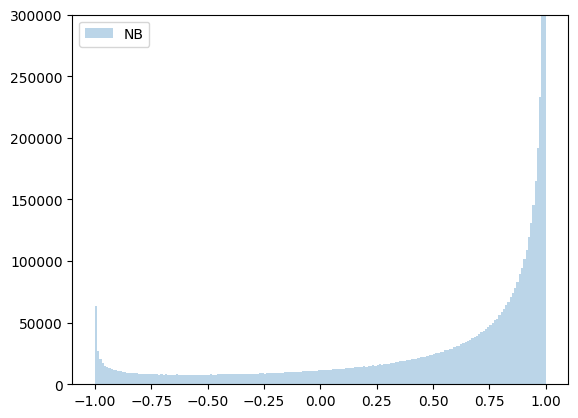

In [32]:
# # Pick a random sample of phase locking matrix
# C_idxs = random.choices(GS_C, k=50)
# # np.fill_diagonal(t_iFC_noles[idxs], np.nan)
# plt.hist(t_iFC_noles[C_idxs].flatten(), bins = 200, alpha = 0.3, label='C');

# B_idxs = random.choices(GS_B, k=50)
# # np.fill_diagonal(t_iFC_noles[idxs], np.nan)
# plt.hist(t_iFC_noles[idxs].flatten(), bins = 200, alpha = 0.3, label='B');

idxs = random.choices(GS_NB, k=50)

# np.fill_diagonal(t_iFC_noles[idxs], np.nan)
plt.hist(t_iFC_noles[idxs].flatten(), bins = 200, alpha = 0.3, label='NB');
plt.ylim(0,300000)
plt.legend()

(50, 345, 345)


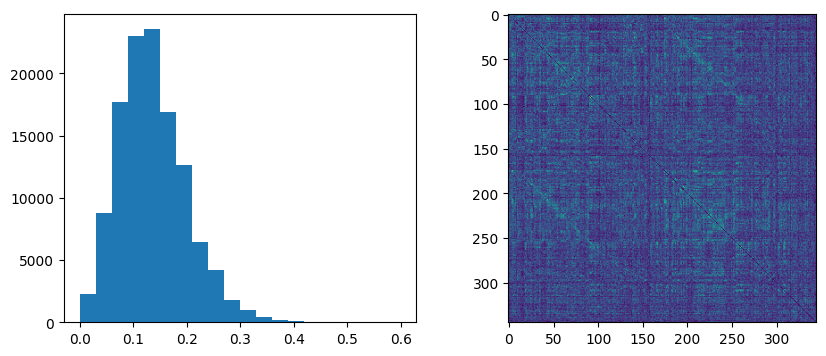

In [83]:
mmm = np.empty((0,345,345))
for p,pisello in enumerate(NB_idxs):
    np.fill_diagonal(t_iFC_noles[pisello], 0)
    m2 = t_iFC_noles[pisello]
    m2 = np.abs(m2)
#     fig = plt.figure()
#     plt.imshow(m2)
#     print(m2.max())
    m2[np.where(m2<0.99)] = 0
#     fig = plt.figure()
#     plt.imshow(m2)
    mmm = np.concatenate((mmm, np.expand_dims(m2, axis=0)))
#     fig = plt.figure()
#     plt.hist(m2.flatten(), bins=100)
    
    if p==50:
        break
print(mmm.shape)
fig,axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(mmm.mean(axis=0).flatten(), bins=20);
axs[1].imshow(mmm.mean(axis=0));


In [84]:
############################
### PERCOLATION ANALYSIS ###
############################

# Guardo come variano le metriche (tipo average shortest path e number of connected components) al variare della
# threshold che applico per binarizzare il grafo.
# Dovrei anche guardare cosa succede se vario la threshold che uso per le singole matrice di phase locking, ma lo
# facciamo un'altra volta

C_mets = []
B_mets = []
NB_mets = []

C_mets_2 = []
B_mets_2 = []
NB_mets_2 = []
x = np.arange(0.2,0.6,0.015)
for thresh_2 in x:
    print(thresh_2)
    thresh = 0.99
#     thresh_2 = 0.5
    n_pick = 15
    
    C_met = []
    B_met = []
    NB_met = []
    
    C_met_2 = []
    B_met_2 = []
    NB_met_2 = []
    

    cane_C = np.empty((0,345,345))
    for t in range(n_pick):
        # Pick a random s-ample of phase locking matrix
        C_idxs = random.choices(GS_C, k=25)
        mat = np.empty((0,t_iFC_noles.shape[-2],t_iFC_noles.shape[-1]))
        for j in C_idxs:
            np.fill_diagonal(t_iFC_noles[j], 0) # Remove ones on the diagonal
            m = t_iFC_noles[j]
            m = np.abs(m)
            m[np.where(m<thresh)] = 0
            mat = np.concatenate((mat, np.expand_dims(m, axis=0)))
        meanchia = mat.mean(axis=0)
        # Devo thresholdare pure la matrice media
        meanchia[np.where(meanchia<thresh_2)] = 0

        cane_C = np.concatenate((cane_C, np.expand_dims(meanchia, axis=0)))
        # fig, axs = plt.subplots(1,2, figsize=(9,4))
        # axs[0].imshow(meanchia)
        # axs[1].hist(meanchia.flatten(), bins=10, label='C',alpha=0.5);    
        # plt.hist(meanchia.flatten(), bins=100, label='C',alpha=0.5);  
        # MEANCHIA DEVO TRESHOLDARLA PRIMA DI CREARE IL GRAFO
        G = nx.from_numpy_matrix(meanchia)
        # Which metrics I want to look at
        C_met.append(graph_metrics('average_shortest_path', G))
#         C_met_2.append(graph_metrics('number_connected_components', G))
    print(np.mean(C_met))


    cane_B = np.empty((0,345,345))
    for t in range(n_pick):
        # Pick a random s-ample of phase locking matrix
        B_idxs = random.choices(GS_B, k=25)
        mat = np.empty((0,t_iFC_noles.shape[-2],t_iFC_noles.shape[-1]))
        for j in B_idxs:
            np.fill_diagonal(t_iFC_noles[j], 0) # Remove ones on the diagonal
            m = t_iFC_noles[j]
            m = np.abs(m)
            m[np.where(m<thresh)] = 0
            mat = np.concatenate((mat, np.expand_dims(m, axis=0)))
        meanchia = mat.mean(axis=0)
        # Devo thresholdare pure la matrice media
        meanchia[np.where(meanchia<thresh_2)] = 0

        cane_B = np.concatenate((cane_B, np.expand_dims(meanchia, axis=0)))
        # fig, axs = plt.subplots(1,2, figsize=(9,4))
        # axs[0].imshow(meanchia)
        # axs[1].hist(meanchia.flatten(), bins=10, label='C',alpha=0.5);    
        # plt.hist(meanchia.flatten(), bins=100, label='C',alpha=0.5);  
        # MEANCHIA DEVO TRESHOLDARLA PRIMA DI CREARE IL GRAFO
        G = nx.from_numpy_matrix(meanchia)
        # Which metrics I want to look at
        B_met.append(graph_metrics('average_shortest_path', G))
#         B_met_2.append(graph_metrics('number_connected_components', G))
    print(np.mean(B_met))

    cane_NB = np.empty((0,345,345))
    for t in range(n_pick):
        # Pick a random s-ample of phase locking matrix
        NB_idxs = random.choices(GS_NB, k=25)
        mat = np.empty((0,t_iFC_noles.shape[-2],t_iFC_noles.shape[-1]))
        for j in NB_idxs:
            np.fill_diagonal(t_iFC_noles[j], 0) # Remove ones on the diagonal
            m = t_iFC_noles[j]
            m = np.abs(m)
            m[np.where(m<thresh)] = 0
            mat = np.concatenate((mat, np.expand_dims(m, axis=0)))
        meanchia = mat.mean(axis=0)
        # Devo thresholdare pure la matrice media
        meanchia[np.where(meanchia<thresh_2)] = 0

        cane_NB = np.concatenate((cane_NB, np.expand_dims(meanchia, axis=0)))
        # fig, axs = plt.subplots(1,2, figsize=(9,4))
        # axs[0].imshow(meanchia)
        # axs[1].hist(meanchia.flatten(), bins=10, label='C',alpha=0.5);    
        # plt.hist(meanchia.flatten(), bins=100, label='C',alpha=0.5);  
        # MEANCHIA DEVO TRESHOLDARLA PRIMA DI CREARE IL GRAFO
        G = nx.from_numpy_matrix(meanchia)
        # Which metrics I want to look at
        NB_met.append(graph_metrics('average_shortest_path', G))
#         NB_met_2.append(graph_metrics('number_connected_components', G))
    print(np.mean(NB_met))

    C_mets.append(C_met)
    B_mets.append(B_met)
    NB_mets.append(NB_met)
    
#     C_mets_2.append(C_met_2)
#     B_mets_2.append(B_met_2)
#     NB_mets_2.append(NB_met_2)

# fig, axs = plt.subplots(1,3, figsize=(13,4))
# axs[0].imshow(cane_C)
# axs[1].imshow(cane_B)
# axs[2].imshow(cane_NB)

0.2
1.867433783277864
1.9594077482695134
1.940422001917431
0.21500000000000002
1.848543983822043
1.9560423682208212
1.9135539984205923
0.23000000000000004
1.8602393513619029
1.92140573847142
1.9171150942179624
0.24500000000000005
2.1354164770765527
2.3530251721302884
2.260276196175746
0.26000000000000006
2.2608038013282226
2.2473430836938864
2.3358441281273037
0.2750000000000001
2.250707505795565
2.304673535291092
2.3039146119472926
0.2900000000000001
2.737177043294746
2.881950381521491
3.0363551732916436
0.3050000000000001
2.776064610507653
3.022517430397913
2.976748024353529
0.3200000000000001
3.947660057563296
3.868852887137803
4.225935509529574
0.33500000000000013
3.7100883132455986
3.813886771444869
4.028842274524733
0.35000000000000014
3.4914730851775375
3.667058518185605
3.7080382288457807
0.36500000000000016
4.307798007885369
5.060043525043064
4.741015063141128
0.38000000000000017
4.636236024741005
4.8268020089136705
5.434300718867239
0.3950000000000002
5.007104307720054
4.9197

C - Percolation phase transition at threshold equal to  0.23000000000000004
B - Percolation phase transition at threshold equal to  0.5150000000000003
NB - Percolation phase transition at threshold equal to  0.23000000000000004


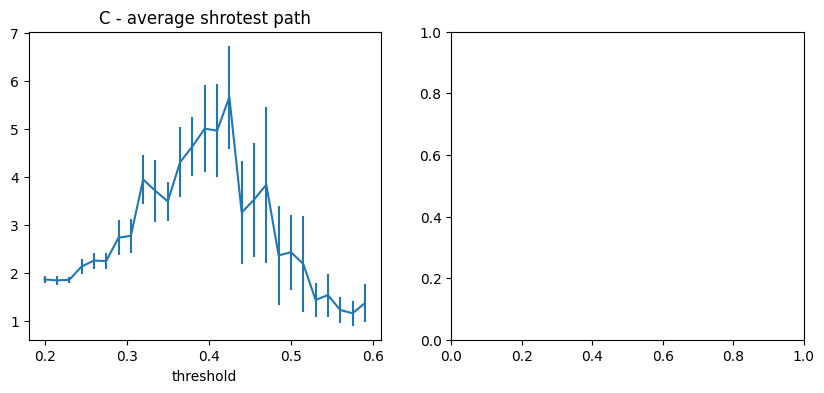

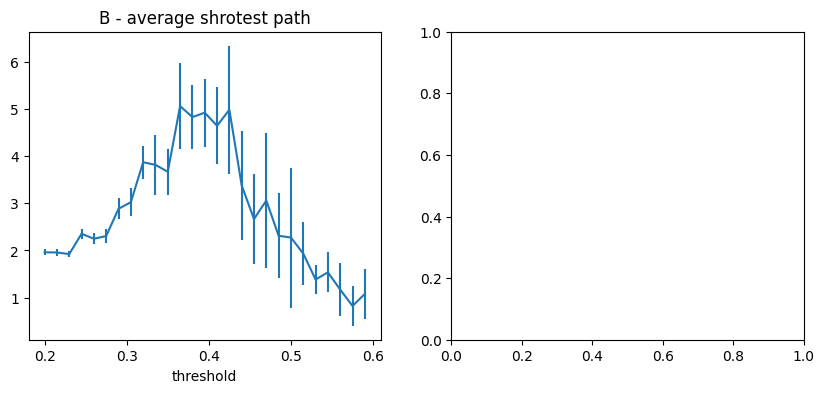

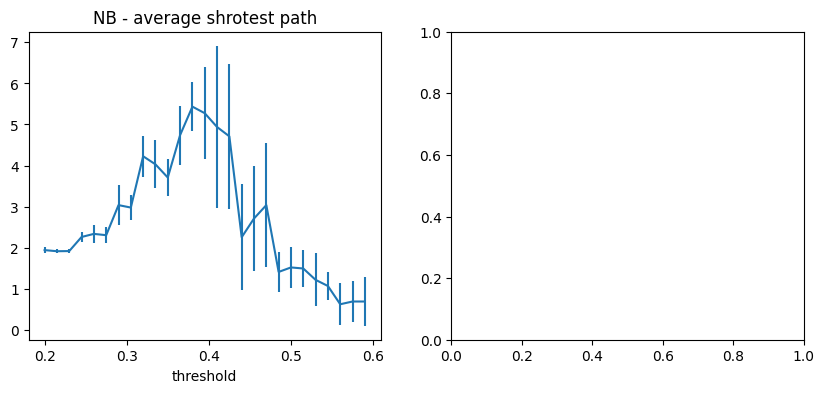

In [85]:
y_C = []
y_err_C = []
for m in C_mets:
    y_C.append(np.mean(m))
    y_err_C.append(np.std(m))
    
y_B = []
y_err_B = []
for m in B_mets:
    y_B.append(np.mean(m))
    y_err_B.append(np.std(m))

y_NB = []
y_err_NB = []
for m in NB_mets:
    y_NB.append(np.mean(m))
    y_err_NB.append(np.std(m))
    
# y_2 = []
# y_err_2 = []
# for m in C_mets_2:
#     y_2.append(np.mean(m))
#     y_err_2.append(np.std(m))
    
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].set_title('C - average shrotest path')
axs[0].errorbar(x, y_C, yerr=y_err_C)
axs[0].set_xlabel('threshold')
# axs[1].set_title('number of connected components')
# axs[1].errorbar(x, y_2, yerr=y_err_2)
# axs[1].set_xlabel('threshold')

fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].set_title('B - average shrotest path')
axs[0].errorbar(x, y_B, yerr=y_err_B)
axs[0].set_xlabel('threshold')
# axs[1].set_title('number of connected components')
# axs[1].errorbar(x, y_2, yerr=y_err_2)
# axs[1].set_xlabel('threshold')

fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].set_title('NB - average shrotest path')
axs[0].errorbar(x, y_NB, yerr=y_err_NB)
axs[0].set_xlabel('threshold')
# axs[1].set_title('number of connected components')
# axs[1].errorbar(x, y_2, yerr=y_err_2)
# axs[1].set_xlabel('threshold')

# Find the threshold correspondnig to the percolation phase transition - minimum value
# of the derivative of average shortest path
dy_C = []
i_prev = y_C[0]
ics_prev = x[0]
for i,ics in zip(y_C[1:],x[1:]):
    dy_C.append(np.abs((i-i_prev)/(ics-ics_prev)))
idx_C = np.argmin(dy_C)
print('C - Percolation phase transition at threshold equal to ', x[idx_C+1])

dy_B = []
i_prev = y_B[0]
ics_prev = x[0]
for i,ics in zip(y_B[1:],x[1:]):
    dy_B.append(np.abs((i-i_prev)/(ics-ics_prev)))
idx_B = np.argmin(dy_B)
print('B - Percolation phase transition at threshold equal to ', x[idx_B+1])

dy_NB = []
i_prev = y_NB[0]
ics_prev = x[0]
for i,ics in zip(y_NB[1:],x[1:]):
    dy_NB.append(np.abs((i-i_prev)/(ics-ics_prev)))
idx_NB = np.argmin(dy_NB)
print('NB - Percolation phase transition at threshold equal to ', x[idx_NB+1])

number_connected_components
size_giant_component
average_shortest_path
global_average_shortest_path
fraction_of_edges
average_degree


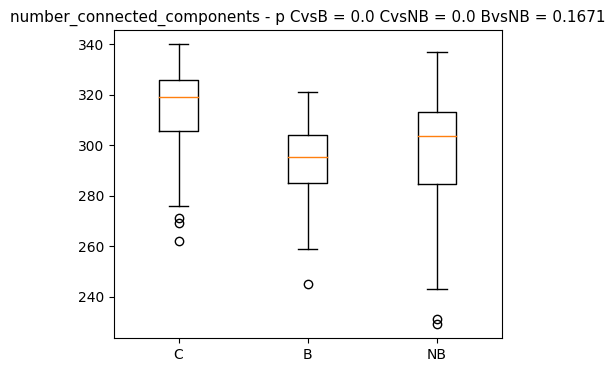

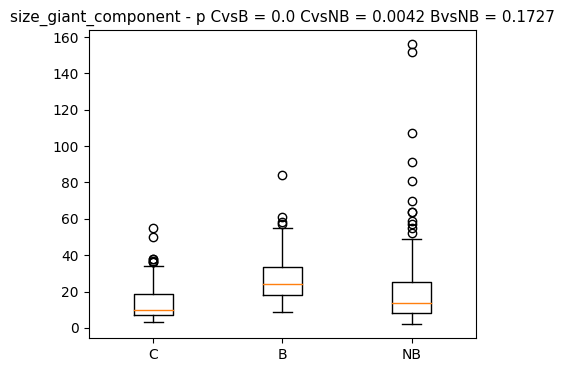

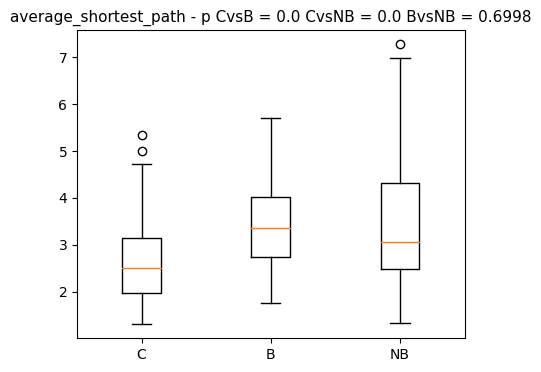

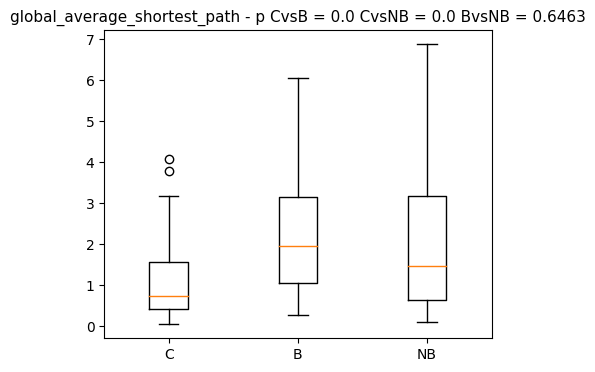

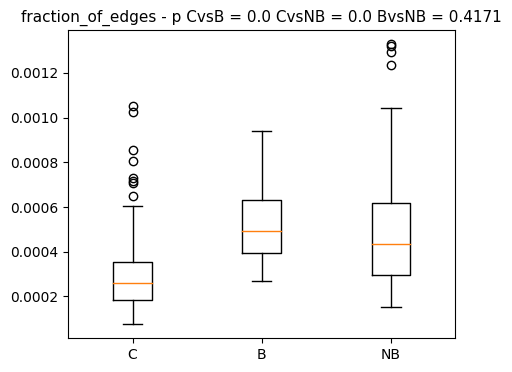

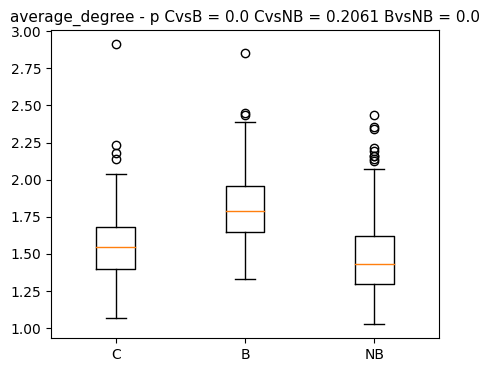

In [112]:
# Once I compute the optimal threshold I can compare metrics between groups
metriche = ['number_connected_components','size_giant_component','average_shortest_path',
            'global_average_shortest_path','fraction_of_edges','average_degree']
# metriche = ['average_degree']
for metrica in metriche:
    print(metrica)
    n_pick = 100
    C_met = []
    B_met = []
    NB_met = []

    C_met_2 = []
    B_met_2 = []
    NB_met_2 = []

    thresh_2 = x[np.argmax(y_C)]
    cane_C = np.empty((0,345,345))
    for t in range(n_pick):
        # Pick a random s-ample of phase locking matrix
        C_idxs = random.choices(GS_C, k=50)
        mat = np.empty((0,t_iFC_noles.shape[-2],t_iFC_noles.shape[-1]))
        for j in C_idxs:
            np.fill_diagonal(t_iFC_noles[j], 0) # Remove ones on the diagonal
            m = t_iFC_noles[j]
            m = np.abs(m)
            m[np.where(m<thresh)] = 0
            mat = np.concatenate((mat, np.expand_dims(m, axis=0)))
        meanchia = mat.mean(axis=0)
        # Devo thresholdare pure la matrice media
        meanchia[np.where(meanchia<thresh_2)] = 0

        cane_C = np.concatenate((cane_C, np.expand_dims(meanchia, axis=0)))
        # fig, axs = plt.subplots(1,2, figsize=(9,4))
        # axs[0].imshow(meanchia)
        # axs[1].hist(meanchia.flatten(), bins=10, label='C',alpha=0.5);    
        # plt.hist(meanchia.flatten(), bins=100, label='C',alpha=0.5);  
        # MEANCHIA DEVO TRESHOLDARLA PRIMA DI CREARE IL GRAFO
        G = nx.from_numpy_matrix(meanchia)
        # Which metrics I want to look at
        C_met.append(graph_metrics(metrica, G))
    #         C_met_2.append(graph_metrics('number_connected_components', G))

    thresh_2 = x[np.argmax(y_B)]
    cane_B = np.empty((0,345,345))
    for t in range(n_pick):
        # Pick a random s-ample of phase locking matrix
        B_idxs = random.choices(GS_B, k=100)
        mat = np.empty((0,t_iFC_noles.shape[-2],t_iFC_noles.shape[-1]))
        for j in B_idxs:
            np.fill_diagonal(t_iFC_noles[j], 0) # Remove ones on the diagonal
            m = t_iFC_noles[j]
            m = np.abs(m)
            m[np.where(m<thresh)] = 0
            mat = np.concatenate((mat, np.expand_dims(m, axis=0)))
        meanchia = mat.mean(axis=0)
        # Devo thresholdare pure la matrice media
        meanchia[np.where(meanchia<thresh_2)] = 0

        cane_B = np.concatenate((cane_B, np.expand_dims(meanchia, axis=0)))
        # fig, axs = plt.subplots(1,2, figsize=(9,4))
        # axs[0].imshow(meanchia)
        # axs[1].hist(meanchia.flatten(), bins=10, label='C',alpha=0.5);    
        # plt.hist(meanchia.flatten(), bins=100, label='C',alpha=0.5);  
        # MEANCHIA DEVO TRESHOLDARLA PRIMA DI CREARE IL GRAFO
        G = nx.from_numpy_matrix(meanchia)
        # Which metrics I want to look at
        B_met.append(graph_metrics(metrica, G))
    #         B_met_2.append(graph_metrics('number_connected_components', G))

    thresh_2 = x[np.argmax(y_NB)]
    cane_NB = np.empty((0,345,345))
    for t in range(n_pick):
        # Pick a random s-ample of phase locking matrix
        NB_idxs = random.choices(GS_NB, k=50)
        mat = np.empty((0,t_iFC_noles.shape[-2],t_iFC_noles.shape[-1]))
        for j in NB_idxs:
            np.fill_diagonal(t_iFC_noles[j], 0) # Remove ones on the diagonal
            m = t_iFC_noles[j]
            m = np.abs(m)
            m[np.where(m<thresh)] = 0
            mat = np.concatenate((mat, np.expand_dims(m, axis=0)))
        meanchia = mat.mean(axis=0)
        # Devo thresholdare pure la matrice media
        meanchia[np.where(meanchia<thresh_2)] = 0

        cane_NB = np.concatenate((cane_NB, np.expand_dims(meanchia, axis=0)))
        # fig, axs = plt.subplots(1,2, figsize=(9,4))
        # axs[0].imshow(meanchia)
        # axs[1].hist(meanchia.flatten(), bins=10, label='C',alpha=0.5);    
        # plt.hist(meanchia.flatten(), bins=100, label='C',alpha=0.5);  
        # MEANCHIA DEVO TRESHOLDARLA PRIMA DI CREARE IL GRAFO
        G = nx.from_numpy_matrix(meanchia)
        # Which metrics I want to look at
        NB_met.append(graph_metrics(metrica, G))
    #         NB_met_2.append(graph_metrics('number_connected_components', G))

    fig, axs = plt.subplots(1, 1, figsize=(5,4))
    p_1 = ttest_ind(C_met, B_met)[1]
    p_2 = ttest_ind(C_met, NB_met)[1]
    p_3 = ttest_ind(B_met, NB_met)[1]
    axs.set_title(metrica+' - p CvsB = {} CvsNB = {} BvsNB = {}'.format(round(p_1,4), round(p_2,4), round(p_3,4)), fontsize=11)
    axs.boxplot([C_met, B_met, NB_met], labels=['C','B','NB'], showfliers=False);

## PCA dimensionality reduction and global signal states visualization

In [136]:
# GS states
GS_state_whole = np.concatenate((GS_state_C, GS_state_B, GS_state_NB))
GS_state_whole_label = np.concatenate((np.full(GS_state_C.shape[0], 1), 
                                       np.full(GS_state_B.shape[0], 2), 
                                       np.full(GS_state_NB.shape[0], 3)))

# not GS states
not_GS_state_whole = np.concatenate((not_GS_state_C, not_GS_state_B, not_GS_state_NB))
not_GS_state_whole_label = np.concatenate((np.full(not_GS_state_C.shape[0], 1), 
                                           np.full(not_GS_state_B.shape[0], 2), 
                                           np.full(not_GS_state_NB.shape[0], 3)))

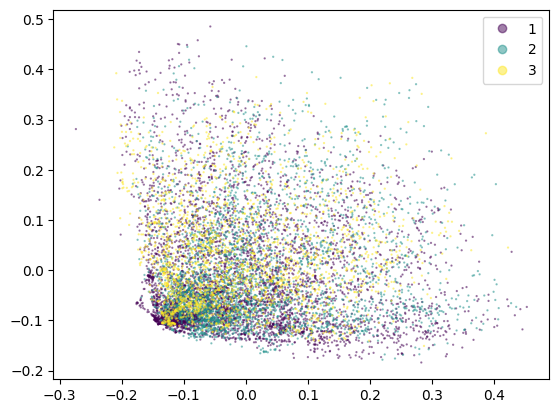

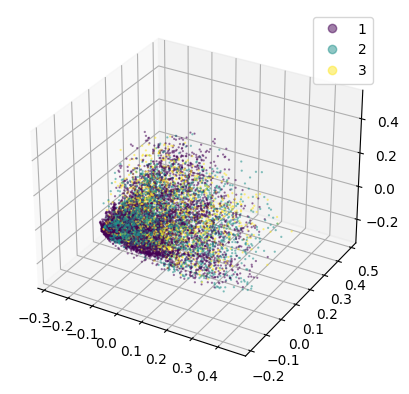

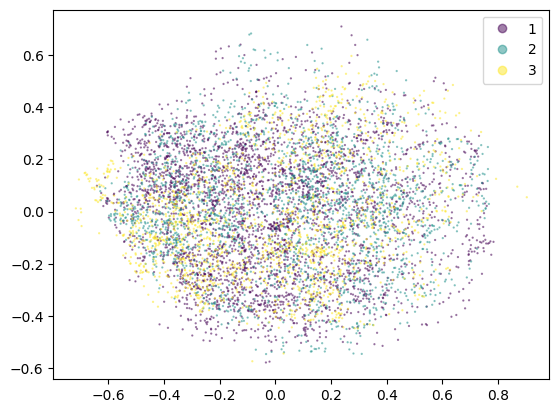

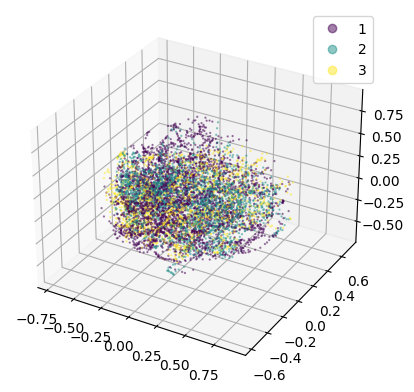

In [138]:
### GS states ###

# Cluster visualzation through PCA
# PCA
pca = sklearn.decomposition.PCA(n_components=3)
pca.fit(GS_state_whole)
GS_state_pca = pca.transform(GS_state_whole)
# exp_var_pca = pca.explained_variance_ratio_
# cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# # plt.title('PCA explained variance')
# # plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# # plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# # plt.ylabel('Explained variance ratio')
# # plt.xlabel('Principal component index')
# # plt.legend(loc='best')
# # plt.tight_layout()
# # plt.show()

# 2D
fig, ax = plt.subplots()
scat = ax.scatter(GS_state_pca[:,0], GS_state_pca[:,1], c = GS_state_whole_label, s=0.4, alpha=0.5)
# scat = ax.scatter(V1_pca[:,0], V1_pca[:,1], c = group_labels, s=0.4, alpha=0.5)
plt.legend(*scat.legend_elements())

# 3D
fig=plt.figure()
ax = plt.axes(projection='3d')
scat = ax.scatter3D(GS_state_pca[:,0], GS_state_pca[:,1], GS_state_pca[:,2], c = GS_state_whole_label, s=0.4, alpha=0.5)
# scat = ax.scatter3D(V1_pca[:,0], V1_pca[:,1], V1_pca[:,2], c = group_labels, s=0.4, alpha=0.5)
plt.legend(*scat.legend_elements())

### not GS states ###
# Cluster visualzation through PCA
# PCA
pca = sklearn.decomposition.PCA(n_components=3)
pca.fit(not_GS_state_whole)
not_GS_state_pca = pca.transform(not_GS_state_whole)
# exp_var_pca = pca.explained_variance_ratio_
# cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# # plt.title('PCA explained variance')
# # plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# # plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# # plt.ylabel('Explained variance ratio')
# # plt.xlabel('Principal component index')
# # plt.legend(loc='best')
# # plt.tight_layout()
# # plt.show()

# 2D
fig, ax = plt.subplots()
scat = ax.scatter(not_GS_state_pca[:,0], not_GS_state_pca[:,1], c = not_GS_state_whole_label, s=0.4, alpha=0.5)
# scat = ax.scatter(V1_pca[:,0], V1_pca[:,1], c = group_labels, s=0.4, alpha=0.5)
plt.legend(*scat.legend_elements())

# 3D
fig=plt.figure()
ax = plt.axes(projection='3d')
scat = ax.scatter3D(not_GS_state_pca[:,0], not_GS_state_pca[:,1], not_GS_state_pca[:,2],
                    c = not_GS_state_whole_label, s=0.4, alpha=0.5)
# scat = ax.scatter3D(V1_pca[:,0], V1_pca[:,1], V1_pca[:,2], c = group_labels, s=0.4, alpha=0.5)
plt.legend(*scat.legend_elements())

### 3.2.2 - Compute similarities between GLOBAL SIGNAL STATES

In [92]:
less=True
if less:
    m=345
else:
    m=394

GS_state_C = np.empty((0,m))
GS_state_B = np.empty((0,m))
GS_state_NB = np.empty((0,m))
for i in range(len(GS_states_idx)):
    idx = np.where(g_state_labels[i]==GS_states_idx[i])[0] # which eigenvectors are associated to global state
    if i==0:
        GS_state_C = V1_groups[i][idx]
    elif i==1:
        GS_state_B = V1_groups[i][idx]
    else:
        GS_state_NB = V1_groups[i][idx]
    

In [96]:
# # Comparison between group of one components of the global signal state
# c = ['blue','green','red']
# bp = plt.boxplot([np.abs(GS_state_C[:,150]), np.abs(GS_state_B[:,150]), np.abs(GS_state_NB[:,150])], positions=[0,1,2],
#                  showfliers=False,
#                  patch_artist=True,
#                  labels=['C', 'B', 'NB']);
# bp['boxes'][0].set_facecolor('blue')
# bp['boxes'][1].set_facecolor('green')
# bp['boxes'][2].set_facecolor('red')

In [ ]:
# Distance between each eigenvector belonging to the GS state and thje centroids
GS_state_all = [GS_state_C, GS_state_B, GS_state_NB]
dist_all = []
for i,centr in enumerate(GS_states):
    dist = []
    for v in GS_state_all[i]: 
        dist.append(euclidean(centr, v))
    dist_all.append(dist)

c = ['blue','green','red']
plt.title('GLOBAL SIGNAL STATE - Distance from centroid')
bp = plt.boxplot(dist_all, positions=[0,1,2],
                 showfliers=False,
                 patch_artist=True,
                 labels=['C', 'B', 'NB']);
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('green')
bp['boxes'][2].set_facecolor('red')

# t-tests 
print('CvsB', ttest_ind(dist_all[0], dist_all[1]))
print('CvsNB', ttest_ind(dist_all[0], dist_all[2]))
print('BvsNB', ttest_ind(dist_all[1], dist_all[2]))
print('\n')

In [ ]:
GS_state_C.shape

### Occupancy and lifetime of global signal states

In [ ]:
for g in g_state_labels:
    print(g.shape)

In [ ]:
# OCCUPANCY
GS_occup = []

labelzz = ['Controls', 'Blindsight', 'No-Blindsight']

print('STATE COUNT FOR EACH POPULATION\n')
print('\n')
# Loop over groups
for i,g in enumerate(g_state_labels):
    print(labelzz[i])
    occup =  []
    gs = GS_states_idx[i]
    # Loop over subjects
    count = []
    for s in range(groups_num[i]):
        sub = g[s*time_points:(s+1)*time_points]
        c = np.sum(sub==gs)/sub.shape[0]
        occup.append(c)
    GS_occup.append(occup)
print('\n')


# PLOT OCCUPANCY
eps = 0.2
fig = plt.figure()
plt.title('STATES OCCUPANCY')
#     plt.ylim(0,1)
bp = plt.boxplot(GS_occup, 
                 positions = [0, 1, 2],
                 labels=labelzz,
                 patch_artist=True)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('green')
bp['boxes'][2].set_facecolor('red')

# t-tests 
print('STATE ', i+1)
print('CvsB', ttest_ind(GS_occup[0], GS_occup[1]))
print('CvsNB', ttest_ind(GS_occup[0], GS_occup[2]))
print('BvsNB', ttest_ind(GS_occup[1], GS_occup[2]))
print('\n')
    
plt.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], ['C', 'B', 'NB'], loc='upper left')

### 3.2.3 - Dimensionality reduction of global states between groups

In [ ]:
# DATA NORMALIZATION
X = np.concatenate((GS_state_C, GS_state_B, GS_state_NB))
std = X.std(axis=0)
mean = X.mean(axis=0)
maxx = np.abs(X).max(axis=0)
X_new = np.empty((0,X.shape[-1]))
for x in X:
    X_new = np.concatenate((X_new, np.expand_dims(np.divide(x,maxx), axis=0)), axis=0)
X_norm = X_new
# X_norm = (X - mean)/std
plt.barh(range(X_norm.shape[1]), X_norm[0])

In [ ]:
# U-MAP REPRESENTATION

g_names = ['CONTROLS', 'BLINDSIGHT', 'NON-BLINDSIGHT']
coloroni = np.concatenate((np.full((GS_state_C.shape[0], 1), 0),
                           np.full((GS_state_B.shape[0], 1), 1),
                           np.full((GS_state_NB.shape[0], 1), 2)))

reducer = umap.UMAP(n_neighbors=15)
# reducer = umap.UMAP()
reducer.fit(X_norm)
embedding = reducer.transform(X_norm)
fig = plt.figure()
# plt.title(g_names[idx])
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.8, s=0.1,
    c=coloroni)
# plt.colorbar(boundaries=np.arange(n_class+1)-0.5).set_ticks(np.arange(n_class))
plt.gca().set_aspect('equal', 'datalim')

In [ ]:
# PCA
pca = sklearn.decomposition.PCA(n_components=0.95)
pca.fit(X_norm)
X_pca = pca.transform(X_norm)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.title('PCA explained variance')
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
X_pca.shape

In [ ]:
# TSNE
TSNE = sklearn.manifold.TSNE()
embedding = TSNE.fit_transform(np.concatenate((GS_state_C, GS_state_B, GS_state_NB)))
embedding = TSNE.fit_transform(X_pca[:,:100])
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.8, s=0.1,
    c=coloroni)
plt.colorbar(boundaries=np.arange(3+1)-0.5).set_ticks(range(3))

### 3.2.3 - Compute similarities between all the possible couple of states in order to find the right associations

In [ ]:
# similarity = cosine_similarity
similarity = euclidean
state_names = [1,2,3,4]
couples = [[0,1], [0,2], [1,2]] # CvsB, CvsNB, BvsNB
sim_matrix = np.zeros((3, num_states, num_states))
titles = ['CvsB', 'CvsNB', 'BvsNB']
fig, axs = plt.subplots(1,3 , figsize=(20,5))
for idx,c in enumerate(couples):
    for i in range(num_states):
        for j in range(num_states):
            if i!=j:
                sim_matrix[idx][i][j] = similarity(g_states[c[0]][i], g_states[c[1]][j])
    
    axs[idx].title.set_text(titles[idx])
    sns.heatmap(sim_matrix[idx], linewidth=0.8, xticklabels=state_names, yticklabels=state_names, ax=axs[idx])

### 3.3 - Compute transition probabilities and entropy production rate

In [ ]:
# COUNT THE TRANSITION BETWEEN EACH COUPLE OF STATES
# subject-by-subject
C = int(np.sum(group_labels==0)/490)
B = int(np.sum(group_labels==1)/490)
NB = int(np.sum(group_labels==2)/490)
groups_num = [C, B, NB]

tot = []
prob_trans_list = [] # I save all the prob transition matrices of each subject of each group in a list
for g, g_num in zip(g_state_labels, groups_num):
    print(g_num)
    matrices = np.empty((0, num_states, num_states))
    # Loop over subjects
    to = 0
    for s in range(g_num):
        matrix = np.zeros((num_states, num_states))
        # count the number of transition within each possible couple of states
        prev = int(g[s*time_points])
        for t, tp in enumerate(g[(s*time_points)+1:(s+1)*time_points]):
            tp = int(tp)
            matrix[prev, tp] += 1
            if prev!=tp:
                to += 1 # total number of transitions between different states
            prev = tp
        tot.append(to)
        # matrix normalization to obtain probabilities
        for r,row in enumerate(matrix):
            matrix[r] = matrix[r]/row.sum()
#             matrix[r] = matrix[r]
        # Check nan values
        if np.isnan(matrix).any():
            iid = np.where(np.isnan(matrix))
            matrix[iid] = 0
        matrix = np.expand_dims(matrix, axis=0)
        matrices = np.concatenate((matrices, matrix))
#         print(matrices.shape)
    prob_trans_list.append(matrices)
    
# COMPUTE ENTROPY PRODUCTION
# Controls , Blindsight, No-blindsight
eps = 0.00000000001
Ss_for = []
for ms in prob_trans_list:
    S = []
    for m in ms:
        m = m+eps
        s = 0
        for i in range(m.shape[0]):
            for j in range(m.shape[1]):
                if i!=j: # Remove loop transition when compute transition probability
                    s_ = m[i,j]*np.log(m[i,j]/m[j,i])
                    s += s_
#         print(s)
        S.append(s)
    Ss_for.append(S)
    
fig = plt.figure()
plt.title('Entropy Production - Forward')
bp = plt.boxplot(Ss_for,
                 patch_artist=True,
                 labels=['C', 'B', 'NB'])
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('green')
bp['boxes'][2].set_facecolor('red')

# t-tests 
print(ttest_ind(Ss_for[0], Ss_for[1]))
print(ttest_ind(Ss_for[0], Ss_for[2]))
print(ttest_ind(Ss_for[1], Ss_for[2]))
print('\n')
    
plt.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], 
           ['Controls','Blindsight','No-Blindsight'], 
           loc='upper right')

### 3.4 - ML CLASSIFICATION (XGBOOST) over Global Signal states

In [ ]:
from sklearn import tree
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import shap
import pickle
# from multiprocessing import Pool
import multiprocess as mp # on notebook
import threading
import functools
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
from sklearn import svm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
# Class balancing
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.model_selection import GridSearchCV

In [ ]:
# GRID SEARCH PARAMS
params = { 'learning_rate': [0.1, 0.3],
           'subsample': [0.5, 1.0],
           'colsample_bytree': [0.6, 0.8],
           'colsample_bylevel': [0.6, 0.8],
           'lambda': [2, 3],  
           'alpha': [1, 2]}

In [ ]:
# for train_size in [1,2,3,4]:

# GET A BALANCED DATASET AND PUT SINGLE SUBJECT INSIDE THE TRAINING SET AND THE TEST SET
GS_bysub = [] # [controls, blindsight, no-blindsight]
for i,n in enumerate(groups_num):
    gs = GS_states_idx[i]
    g_lab = g_state_labels[i] # state label
    g = V1_groups[i] # eigenvectors

    # Loop over subjects
    vecs = []
    for s in range(n):
        sub_g_lab = g_lab[s*time_points:(s+1)*time_points]
        sub_g = g[s*time_points:(s+1)*time_points]
        tp = np.where(sub_g_lab==gs) # GS time points
        vecs.append(sub_g[tp])
    GS_bysub.append(vecs)

for train_size in [4]:
    # Make a statistics over different sampling of subjects and balancing
    reps = 5
    accuracies = []
    accuracies_in = []
    for k in range(reps):
        # Split train and test set subject-wise
    #     train_size = 3 # trainig set size in terms of subjects 
        test_size = 5 - train_size
        X_train = np.empty((0, 394)) 
        Y_train = np.empty((0, 1))
        X_test = np.empty((0, 394)) 
        Y_test = np.empty((0, 1))
        for c,g in enumerate(GS_bysub):
            # Training set
            subset_train = random.sample(range(len(g)), train_size)
            for i in subset_train:
                X_train = np.concatenate((X_train, g[i]), axis=0)
                Y_train = np.concatenate((Y_train, np.full((g[i].shape[0], 1), c)), axis=0)
                # Balance the classe with respect to the single samples (the eigenvector)
                under_sampler = RandomUnderSampler(random_state=42)

            # Test set
            base = [k for k in range(len(g)) if k not in subset_train]
            subset_test = random.sample(base, test_size)
            for i in subset_test:
                X_test = np.concatenate((X_test, g[i]), axis=0)
                Y_test = np.concatenate((Y_test, np.full((g[i].shape[0], 1), c)), axis=0)

        X_train_bal, Y_train_bal = under_sampler.fit_resample(X_train, Y_train)
    #     print(f"Training target statistics: {Counter(Y_train_bal)}")
        X_test_bal, Y_test_bal = under_sampler.fit_resample(X_test, Y_test)
    #     print(f"Training target statistics: {Counter(Y_test_bal)}")

        # print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

        # XBOOST CLASSIFICATION

        xgb = XGBClassifier()
        clf = GridSearchCV(estimator=xgb, 
                           cv=2,
                           param_grid=params,
                           scoring='accuracy', 
                           verbose=1)
        # np.random.shuffle(Y_train)
        clf.fit(X_train_bal, Y_train_bal)
        best_model = clf.best_estimator_
        print(clf.best_params_)
        
        y_pred_test = best_model.predict(X_test_bal) # prediction over test samples
        y_pred_train = best_model.predict(X_train_bal)
        accuracy = metrics.accuracy_score(Y_test_bal, y_pred_test) # test accuracy
        accuracy_in = metrics.accuracy_score(Y_train_bal, y_pred_train) # test accuracy
        
        accuracies.append(accuracy)
        accuracies_in.append(accuracy_in)
        
    print('test: ', np.mean(accuracies), 'train: ', np.mean(accuracies_in), 'train size: ', X_train_bal.shape[0], 'test size: ', X_test_bal.shape[0])


In [ ]:
# ALL THE SUBJECTS ARE SHUFFLED BETWEEN TRAINING AND TEST SET

X = np.concatenate((GS_state_C, GS_state_B, GS_state_NB), axis=0)
Y = np.concatenate((np.full((GS_state_C.shape[0], 1), 0),
                    np.full((GS_state_B.shape[0], 1), 1),
                    np.full((GS_state_NB.shape[0], 1), 2)))
for ts in [0.2, 0.4, 0.6, 0.8]:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=ts, random_state=42)
    clf = XGBClassifier()
    # np.random.shuffle(Y_train)
    clf.fit(X_train, Y_train)
    y_pred_test = clf.predict(X_test) # prediction over test samples
    y_pred_train = clf.predict(X_train)
    accuracy = metrics.accuracy_score(Y_test, y_pred_test) # test accuracy
    accuracy_in = metrics.accuracy_score(Y_train, y_pred_train) # test accuracy
    print('test: ', accuracy, 'train: ', accuracy_in, 'train size: ', X_train.shape[0], 'test size: ', X_test.shape[0])

#     confusion_matrix(Y_test, y_pred_test)

# 4.0 - Discrete Dynamical maps from leading eigenvalues time series

In [ ]:
# Provo a creare una mappa (nel senso di sistemi dinamici)
# Soggetto per soggetto, prendo l'autovalore del leading eigenvector come espressione dell'attività funzionale
# in quell'istante e plotto la mappa lamba_t vs lambda_t+1 

In [ ]:
# for s in range(len(patients_paths)):
#     fig =plt.figure()
#     plt.plot(W1[s*time_points:(s+1)*time_points])

In [ ]:
step = 1
for s in range(len(patients_paths)):
    p = np.asarray([W1[s*time_points+0],W1[s*time_points+step]])
    for i in range(s*time_points+step, (s+1)*time_points, step):
        p_next = np.asarray([W1[i],W1[i+step]]) 
        p = np.hstack((p, p_next))
    fig = plt.figure(figsize=(5,5))
    plt.scatter(p[0], p[1], s=0.3)
    plt.xlim(150,360)
    plt.ylim(150,360)